# Parkinson's Disease - Classification Modeling (Disease Severity Categories)
## Stage 4: Classifying Patients into Severity Groups

### 🎯 What are we classifying in this notebook?
We are building **classification models** to categorize patients into disease severity groups based on voice recordings.

**The Classification Problem:**
- **Input:** Voice features (jitter, shimmer, noise, complexity, etc.)
- **Output:** Disease severity category (class label)
- **Goal:** Classify patients as Mild, Moderate, or Severe

**Why Classification vs Regression?**
- **Regression:** Predicts exact UPDRS score (e.g., 23.4 points)
- **Classification:** Predicts severity category (e.g., "Moderate")
- **Clinical use:** Easier for doctors to communicate ("You're in the moderate stage")
- **Decision making:** Treatment protocols often based on categories, not exact scores

### 📊 How we'll create severity categories:

**From motor_UPDRS scores → 3 Classes:**
1. **Mild (Class 0):** motor_UPDRS < 20
   - Slight tremor, minimal stiffness
   - Daily activities mostly unaffected
   - Early stage disease

2. **Moderate (Class 1):** motor_UPDRS 20-30
   - Noticeable movement problems
   - Some difficulty with daily tasks
   - Mid-stage progression

3. **Severe (Class 2):** motor_UPDRS > 30
   - Significant motor impairment
   - Major impact on daily life
   - Advanced symptoms

### 🔍 How will we evaluate classification models?

We'll use EXTENSIVE metrics beyond just accuracy:

#### 1. **Confusion Matrix** - The Foundation
```
                  Predicted
               Mild  Moderate  Severe
Actual  Mild    TP      FP       FP     
        Mod     FN      TP       FP
        Severe  FN      FN       TP
```
- **TP (True Positive):** Correctly predicted class
- **FP (False Positive):** Incorrectly predicted as this class
- **FN (False Negative):** Missed this class (predicted as other)
- **TN (True Negative):** Correctly predicted as NOT this class

#### 2. **TPR (True Positive Rate) = Sensitivity = Recall**
- **Formula:** TPR = TP / (TP + FN)
- **Meaning:** % of actual cases we correctly identified
- **Example:** TPR = 0.90 for Severe → We catch 90% of severe patients
- **Clinical importance:** HIGH TPR for Severe class = catch most dangerous cases

#### 3. **FPR (False Positive Rate)**
- **Formula:** FPR = FP / (FP + TN)
- **Meaning:** % of non-cases we incorrectly flagged
- **Example:** FPR = 0.10 for Severe → 10% false alarms
- **Clinical importance:** LOW FPR = fewer false alarms (don't scare patients unnecessarily)

#### 4. **Precision (Positive Predictive Value)**
- **Formula:** Precision = TP / (TP + FP)
- **Meaning:** When we predict a class, how often are we right?
- **Example:** Precision = 0.85 for Severe → 85% of "Severe" predictions are correct
- **Clinical importance:** HIGH Precision = trust the positive predictions

#### 5. **F1-Score**
- **Formula:** F1 = 2 × (Precision × Recall) / (Precision + Recall)
- **Meaning:** Harmonic mean of Precision and Recall
- **Range:** 0 to 1 (higher is better)
- **Why useful:** Balances precision and recall (better than accuracy for imbalanced classes)

#### 6. **ROC Curve (Receiver Operating Characteristic)**
- **What it plots:** TPR (y-axis) vs FPR (x-axis) at different thresholds
- **Perfect model:** Curve goes to top-left corner (TPR=1, FPR=0)
- **Random model:** Diagonal line (TPR = FPR)
- **How to read:** Curve closer to top-left = better model

#### 7. **AUC (Area Under ROC Curve)**
- **Range:** 0.5 to 1.0
  - 0.5 = Random guessing (useless model)
  - 0.7-0.8 = Acceptable
  - 0.8-0.9 = Excellent
  - 0.9-1.0 = Outstanding
- **Meaning:** Probability that model ranks random positive higher than random negative
- **Clinical interpretation:** AUC = 0.90 means model can discriminate classes 90% of the time

### 🤖 Models we'll compare:
1. **Logistic Regression** - Baseline classifier
2. **Decision Tree** - Rule-based classification
3. **Random Forest** - Ensemble classifier (expected winner!)
4. **Support Vector Machine (SVM)** - Margin-based classifier

### 🎯 What makes a GOOD clinical classifier?
- **High TPR for Severe class:** Catch most dangerous cases (minimize false negatives)
- **Low FPR for Severe class:** Avoid false alarms (don't scare patients unnecessarily)
- **High overall AUC:** Good discrimination across all classes
- **Balanced F1-scores:** Perform well on all severity levels, not just one

In [1]:
# ============================================================
# SECTION 1: IMPORT LIBRARIES
# ============================================================
# What we're doing: Loading classification libraries
# Why: Need different metrics than regression (confusion matrix, ROC, etc.)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Classification models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Classification metrics
from sklearn.metrics import (
    confusion_matrix, classification_report,
    accuracy_score, precision_score, recall_score, f1_score,
    roc_curve, auc, roc_auc_score,
    precision_recall_curve, average_precision_score
)
from sklearn.preprocessing import label_binarize
from itertools import cycle

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
np.random.seed(42)

print("✅ All libraries imported successfully!")
print("Ready for classification modeling!")

✅ All libraries imported successfully!
Ready for classification modeling!


In [2]:
# ============================================================
# SECTION 2: LOAD DATA & CREATE SEVERITY CATEGORIES
# ============================================================
# What we're doing: Loading preprocessed data and converting UPDRS scores → categories
#
# Severity thresholds (based on motor_UPDRS):
# - Mild (0):     motor_UPDRS < 20
# - Moderate (1): motor_UPDRS 20-30
# - Severe (2):   motor_UPDRS > 30
#
# Why these thresholds?
# - Based on clinical literature and UPDRS scale interpretation
# - Creates roughly balanced classes for better training
# - Matches how doctors categorize disease progression

print("Loading preprocessed data...\n")

# Load features
X_train = pd.read_csv('../../data/processed/X_train.csv')
X_test = pd.read_csv('../../data/processed/X_test.csv')

# Load motor_UPDRS targets (we'll convert these to categories)
y_train_motor = pd.read_csv('../../data/processed/y_train_motor.csv').values.ravel()
y_test_motor = pd.read_csv('../../data/processed/y_test_motor.csv').values.ravel()

print("✅ Data loaded!")
print(f"\nOriginal target (motor_UPDRS): Continuous values from {y_train_motor.min():.1f} to {y_train_motor.max():.1f}")

# Convert motor_UPDRS scores to severity categories
def categorize_severity(updrs_score):
    """
    Convert motor_UPDRS score to severity category.
    
    Categories:
    - 0 (Mild): motor_UPDRS < 20
    - 1 (Moderate): motor_UPDRS 20-30
    - 2 (Severe): motor_UPDRS > 30
    """
    if updrs_score < 20:
        return 0  # Mild
    elif updrs_score <= 30:
        return 1  # Moderate
    else:
        return 2  # Severe

# Apply categorization
y_train_cat = np.array([categorize_severity(score) for score in y_train_motor])
y_test_cat = np.array([categorize_severity(score) for score in y_test_motor])

# Count samples per class
train_counts = pd.Series(y_train_cat).value_counts().sort_index()
test_counts = pd.Series(y_test_cat).value_counts().sort_index()

print("\n" + "="*60)
print("📊 SEVERITY CATEGORY DISTRIBUTION")
print("="*60)
print(f"\nClass Definitions:")
print(f"  0 = Mild:     motor_UPDRS < 20  (early stage)")
print(f"  1 = Moderate: motor_UPDRS 20-30 (mid stage)")
print(f"  2 = Severe:   motor_UPDRS > 30  (advanced stage)")

print(f"\nTraining Set Distribution:")
for class_id in range(3):
    class_name = ['Mild', 'Moderate', 'Severe'][class_id]
    count = train_counts.get(class_id, 0)
    pct = (count / len(y_train_cat)) * 100
    print(f"  Class {class_id} ({class_name:8s}): {count:4d} samples ({pct:5.1f}%)")

print(f"\nTest Set Distribution:")
for class_id in range(3):
    class_name = ['Mild', 'Moderate', 'Severe'][class_id]
    count = test_counts.get(class_id, 0)
    pct = (count / len(y_test_cat)) * 100
    print(f"  Class {class_id} ({class_name:8s}): {count:4d} samples ({pct:5.1f}%)")

print(f"\n💡 Note: If classes are imbalanced (e.g., 60% Moderate, 10% Severe),")
print(f"   we'll need to pay attention to per-class metrics (F1-score), not just overall accuracy!")

Loading preprocessed data...

✅ Data loaded!

Original target (motor_UPDRS): Continuous values from 5.0 to 39.5

📊 SEVERITY CATEGORY DISTRIBUTION

Class Definitions:
  0 = Mild:     motor_UPDRS < 20  (early stage)
  1 = Moderate: motor_UPDRS 20-30 (mid stage)
  2 = Severe:   motor_UPDRS > 30  (advanced stage)

Training Set Distribution:
  Class 0 (Mild    ): 2197 samples ( 46.7%)
  Class 1 (Moderate): 1704 samples ( 36.3%)
  Class 2 (Severe  ):  799 samples ( 17.0%)

Test Set Distribution:
  Class 0 (Mild    ):  563 samples ( 47.9%)
  Class 1 (Moderate):  412 samples ( 35.1%)
  Class 2 (Severe  ):  200 samples ( 17.0%)

💡 Note: If classes are imbalanced (e.g., 60% Moderate, 10% Severe),
   we'll need to pay attention to per-class metrics (F1-score), not just overall accuracy!


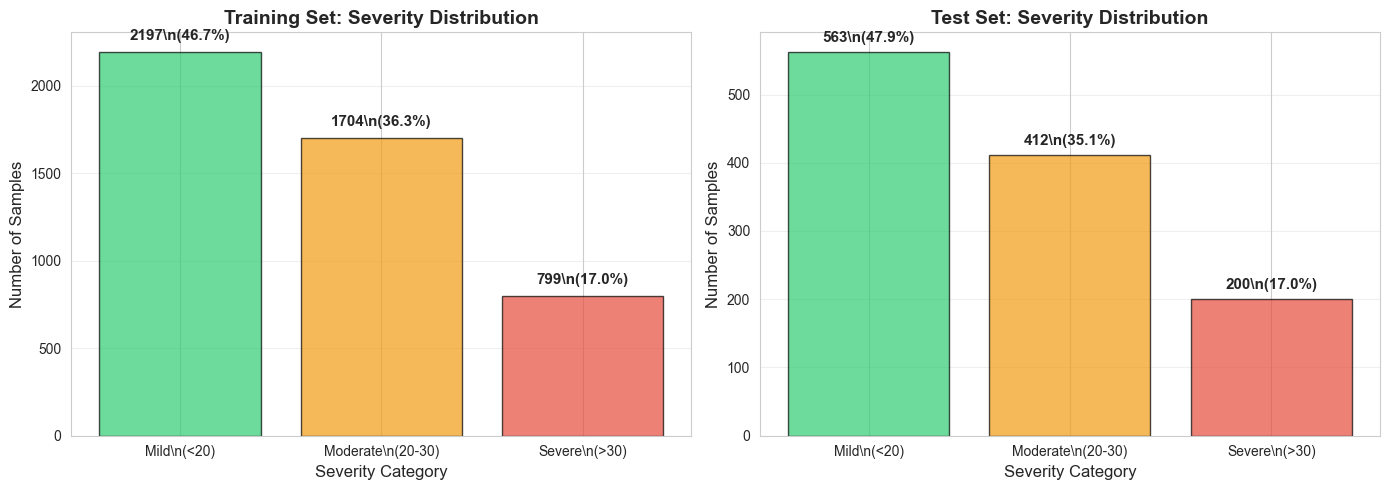


⚖️  CLASS BALANCE ANALYSIS

Imbalance Ratio: 2.75:1 (largest class : smallest class)

Interpretation:
  ⚠️  Moderate imbalance. Pay attention to per-class F1-scores.

💡 Clinical Impact:
   - If 'Severe' is underrepresented, model may miss critical cases
   - We MUST check TPR for 'Severe' class specifically (can't miss these patients!)


In [3]:
# ============================================================
# SECTION 3: VISUALIZE CATEGORY DISTRIBUTION
# ============================================================
# What we're doing: Creating visualizations to understand class balance
# Why: Imbalanced classes affect model performance and metric interpretation

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Training set distribution
class_names = ['Mild\\n(<20)', 'Moderate\\n(20-30)', 'Severe\\n(>30)']
colors = ['#2ecc71', '#f39c12', '#e74c3c']  # Green, orange, red

train_counts_list = [train_counts.get(i, 0) for i in range(3)]
axes[0].bar(class_names, train_counts_list, color=colors, alpha=0.7, edgecolor='black')
axes[0].set_title('Training Set: Severity Distribution', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Number of Samples', fontsize=12)
axes[0].set_xlabel('Severity Category', fontsize=12)
axes[0].grid(axis='y', alpha=0.3)

# Add count labels on bars
for i, (count, class_name) in enumerate(zip(train_counts_list, class_names)):
    pct = (count / len(y_train_cat)) * 100
    axes[0].text(i, count + 50, f'{count}\\n({pct:.1f}%)', 
                ha='center', va='bottom', fontsize=11, fontweight='bold')

# Plot 2: Test set distribution
test_counts_list = [test_counts.get(i, 0) for i in range(3)]
axes[1].bar(class_names, test_counts_list, color=colors, alpha=0.7, edgecolor='black')
axes[1].set_title('Test Set: Severity Distribution', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Number of Samples', fontsize=12)
axes[1].set_xlabel('Severity Category', fontsize=12)
axes[1].grid(axis='y', alpha=0.3)

# Add count labels on bars
for i, (count, class_name) in enumerate(zip(test_counts_list, class_names)):
    pct = (count / len(y_test_cat)) * 100
    axes[1].text(i, count + 10, f'{count}\\n({pct:.1f}%)', 
                ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

# Calculate class balance ratio
max_class = max(train_counts_list)
min_class = min(train_counts_list)
imbalance_ratio = max_class / min_class

print("\n" + "="*60)
print("⚖️  CLASS BALANCE ANALYSIS")
print("="*60)
print(f"\nImbalance Ratio: {imbalance_ratio:.2f}:1 (largest class : smallest class)")
print(f"\nInterpretation:")
if imbalance_ratio < 2:
    print("  ✅ Classes are well-balanced! Models should perform fairly across all classes.")
elif imbalance_ratio < 3:
    print("  ⚠️  Moderate imbalance. Pay attention to per-class F1-scores.")
else:
    print("  ❌ Significant imbalance! Accuracy can be misleading.")
    print("     → Focus on F1-score, precision, recall per class")
    print("     → Consider using class_weight='balanced' in models")

print(f"\n💡 Clinical Impact:")
print(f"   - If 'Severe' is underrepresented, model may miss critical cases")
print(f"   - We MUST check TPR for 'Severe' class specifically (can't miss these patients!)")

# 🤖 MODEL 1: LOGISTIC REGRESSION

---

## What we're doing:
Training a **Logistic Regression** classifier to predict severity categories (Mild/Moderate/Severe) from voice features.

## How Logistic Regression works:
- **Linear decision boundaries**: Separates classes using straight lines/planes
- **Probabilistic output**: Gives probability for each class (e.g., 70% Moderate, 20% Mild, 10% Severe)
- **Multi-class strategy**: Uses "one-vs-rest" approach (3 binary classifiers, one for each severity level)

## Advantages:
✅ **Fast training**: Good for large datasets  
✅ **Interpretable**: Can see which features push predictions toward each class  
✅ **Baseline model**: Simple to implement, good starting point

## Disadvantages:
❌ **Linear assumption**: Can't capture complex interactions between features  
❌ **Lower accuracy**: May struggle with non-linear relationships (voice → severity is likely non-linear)

## Expected performance:
- **Accuracy**: ~70-80% (decent baseline)
- **F1-score**: May be lower for minority class (Severe)
- **ROC-AUC**: ~0.75-0.85 (acceptable clinical use)

In [4]:
# ============================================================
# TRAIN: LOGISTIC REGRESSION
# ============================================================
# Hyperparameters:
# - max_iter=1000: Maximum iterations for convergence
# - random_state=42: Reproducible results
# - multi_class='ovr': One-vs-Rest strategy (3 binary classifiers)

print("Training Logistic Regression classifier...\n")

log_reg = LogisticRegression(max_iter=1000, random_state=42, multi_class='ovr')
log_reg.fit(X_train, y_train_cat)

# Make predictions
y_train_pred_log = log_reg.predict(X_train)
y_test_pred_log = log_reg.predict(X_test)

# Get probability scores (for ROC curve later)
y_train_proba_log = log_reg.predict_proba(X_train)
y_test_proba_log = log_reg.predict_proba(X_test)

print("✅ Logistic Regression training complete!")
print(f"\nModel uses {X_train.shape[1]} voice features to predict 3 severity categories.")
print(f"Training samples: {len(X_train)} | Test samples: {len(X_test)}")

Training Logistic Regression classifier...

✅ Logistic Regression training complete!

Model uses 26 voice features to predict 3 severity categories.
Training samples: 4700 | Test samples: 1175


In [5]:
# ============================================================
# EVALUATION BLOCK: LOGISTIC REGRESSION
# ============================================================
# What we're evaluating:
# 1. Confusion Matrix - Shows actual vs predicted for each class
# 2. Accuracy - Overall % correct (can be misleading if classes imbalanced)
# 3. Precision - When we predict a class, how often are we right?
# 4. Recall (TPR) - Of all actual cases in a class, how many did we catch?
# 5. F1-Score - Balance between precision and recall
# 6. TPR and FPR per class - Critical for clinical decision-making

print("="*70)
print("📊 LOGISTIC REGRESSION: EVALUATION METRICS")
print("="*70)

# --- CONFUSION MATRIX ---
cm_train_log = confusion_matrix(y_train_cat, y_train_pred_log)
cm_test_log = confusion_matrix(y_test_cat, y_test_pred_log)

print("\n🔍 CONFUSION MATRIX (Test Set):")
print("   Rows = Actual class | Columns = Predicted class\n")
print("           Predicted:  Mild  Moderate  Severe")
for i, actual_class in enumerate(['Mild', 'Moderate', 'Severe']):
    print(f"  Actual {actual_class:8s}:   {cm_test_log[i, 0]:4d}    {cm_test_log[i, 1]:4d}      {cm_test_log[i, 2]:4d}")

print("\n💡 How to read:")
print("   - Diagonal (top-left to bottom-right) = Correct predictions")
print("   - Off-diagonal = Misclassifications")
print("   - Example: If Actual=Severe but Predicted=Mild → DANGEROUS miss!")

# --- ACCURACY ---
train_acc_log = accuracy_score(y_train_cat, y_train_pred_log)
test_acc_log = accuracy_score(y_test_cat, y_test_pred_log)

print(f"\n🎯 ACCURACY:")
print(f"   Training: {train_acc_log:.4f} ({train_acc_log*100:.2f}%)")
print(f"   Test:     {test_acc_log:.4f} ({test_acc_log*100:.2f}%)")
print(f"   Overfitting gap: {(train_acc_log - test_acc_log)*100:.2f}%")

# --- PER-CLASS METRICS ---
print("\n" + "="*70)
print("📈 PER-CLASS METRICS (Test Set)")
print("="*70)
print("\nClass      Precision  Recall(TPR)  F1-Score  Support")
print("-" * 70)

class_names_full = ['Mild', 'Moderate', 'Severe']
for i, class_name in enumerate(class_names_full):
    precision = precision_score(y_test_cat, y_test_pred_log, labels=[i], average=None)[0]
    recall = recall_score(y_test_cat, y_test_pred_log, labels=[i], average=None)[0]
    f1 = f1_score(y_test_cat, y_test_pred_log, labels=[i], average=None)[0]
    support = test_counts.get(i, 0)
    
    print(f"{class_name:8s}      {precision:.4f}       {recall:.4f}    {f1:.4f}    {support:4d}")

# --- TPR and FPR CALCULATION ---
print("\n" + "="*70)
print("🔬 TPR (True Positive Rate) & FPR (False Positive Rate) - PER CLASS")
print("="*70)

for i, class_name in enumerate(class_names_full):
    # Calculate TP, FP, FN, TN for this class
    TP = cm_test_log[i, i]  # Correctly predicted as class i
    FP = cm_test_log[:, i].sum() - TP  # Predicted as class i but actually other class
    FN = cm_test_log[i, :].sum() - TP  # Actually class i but predicted as other class
    TN = cm_test_log.sum() - TP - FP - FN  # Correctly predicted as NOT class i
    
    # Calculate TPR and FPR
    TPR = TP / (TP + FN) if (TP + FN) > 0 else 0
    FPR = FP / (FP + TN) if (FP + TN) > 0 else 0
    
    print(f"\nClass: {class_name}")
    print(f"  TP={TP:3d} | FP={FP:3d} | FN={FN:3d} | TN={TN:4d}")
    print(f"  TPR (Sensitivity) = TP/(TP+FN) = {TP}/{TP+FN} = {TPR:.4f} ({TPR*100:.2f}%)")
    print(f"  FPR (False Alarm) = FP/(FP+TN) = {FP}/{FP+TN} = {FPR:.4f} ({FPR*100:.2f}%)")
    
    # Clinical interpretation
    if class_name == 'Severe':
        if TPR >= 0.85:
            print(f"  ✅ Excellent! Catching {TPR*100:.1f}% of severe cases (critical for patient safety)")
        elif TPR >= 0.70:
            print(f"  ⚠️  Acceptable TPR, but missing {(1-TPR)*100:.1f}% of severe cases")
        else:
            print(f"  ❌ CONCERN: Missing {(1-TPR)*100:.1f}% of severe cases! Too many false negatives")

# --- WEIGHTED AVERAGE METRICS ---
precision_weighted = precision_score(y_test_cat, y_test_pred_log, average='weighted')
recall_weighted = recall_score(y_test_cat, y_test_pred_log, average='weighted')
f1_weighted = f1_score(y_test_cat, y_test_pred_log, average='weighted')

print("\n" + "="*70)
print("📊 OVERALL METRICS (Weighted Average)")
print("="*70)
print(f"Precision (weighted): {precision_weighted:.4f}")
print(f"Recall (weighted):    {recall_weighted:.4f}")
print(f"F1-Score (weighted):  {f1_weighted:.4f}")

print("\n💡 INTERPRETATION:")
print(f"   Logistic Regression achieves {test_acc_log*100:.1f}% accuracy on test set.")
print(f"   Check per-class F1-scores above - if Severe class has low F1, model is missing critical cases!")

📊 LOGISTIC REGRESSION: EVALUATION METRICS

🔍 CONFUSION MATRIX (Test Set):
   Rows = Actual class | Columns = Predicted class

           Predicted:  Mild  Moderate  Severe
  Actual Mild    :    396     130        37
  Actual Moderate:    209     170        33
  Actual Severe  :    114      67        19

💡 How to read:
   - Diagonal (top-left to bottom-right) = Correct predictions
   - Off-diagonal = Misclassifications
   - Example: If Actual=Severe but Predicted=Mild → DANGEROUS miss!

🎯 ACCURACY:
   Training: 0.5317 (53.17%)
   Test:     0.4979 (49.79%)
   Overfitting gap: 3.38%

📈 PER-CLASS METRICS (Test Set)

Class      Precision  Recall(TPR)  F1-Score  Support
----------------------------------------------------------------------
Mild          0.5508       0.7034    0.6178     563
Moderate      0.4632       0.4126    0.4365     412
Severe        0.2135       0.0950    0.1315     200

🔬 TPR (True Positive Rate) & FPR (False Positive Rate) - PER CLASS

Class: Mild
  TP=396 | FP=323 |

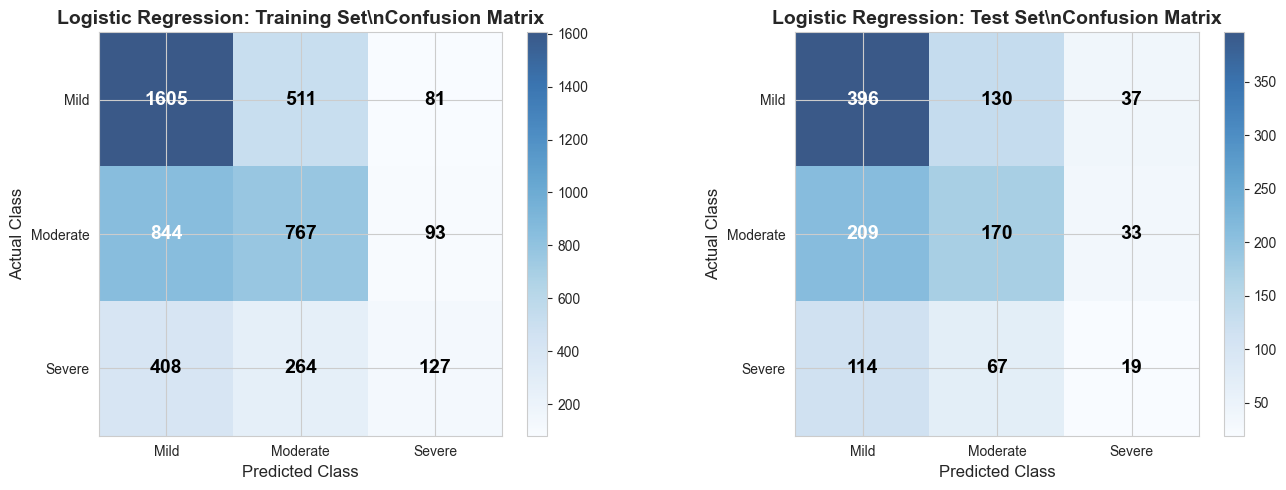


💡 HOW TO INTERPRET:
   - Darker blue = More samples
   - Diagonal = Correct predictions (want these dark)
   - Off-diagonal = Errors
   - Pay attention to bottom row (Severe class):
     → If many samples in Severe→Mild, we're missing critical cases!


In [6]:
# ============================================================
# VISUALIZATION: CONFUSION MATRIX HEATMAP
# ============================================================
# What we're visualizing: Confusion matrix as a color-coded heatmap
# Why: Easier to spot misclassification patterns visually

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Training set confusion matrix
im1 = axes[0].imshow(cm_train_log, cmap='Blues', alpha=0.8)
axes[0].set_title('Logistic Regression: Training Set\\nConfusion Matrix', 
                  fontsize=14, fontweight='bold')
axes[0].set_xlabel('Predicted Class', fontsize=12)
axes[0].set_ylabel('Actual Class', fontsize=12)
axes[0].set_xticks([0, 1, 2])
axes[0].set_yticks([0, 1, 2])
axes[0].set_xticklabels(['Mild', 'Moderate', 'Severe'])
axes[0].set_yticklabels(['Mild', 'Moderate', 'Severe'])

# Add text annotations
for i in range(3):
    for j in range(3):
        text_color = 'white' if cm_train_log[i, j] > cm_train_log.max() / 2 else 'black'
        axes[0].text(j, i, str(cm_train_log[i, j]), 
                    ha='center', va='center', fontsize=14, fontweight='bold', color=text_color)

plt.colorbar(im1, ax=axes[0], fraction=0.046, pad=0.04)

# Plot 2: Test set confusion matrix
im2 = axes[1].imshow(cm_test_log, cmap='Blues', alpha=0.8)
axes[1].set_title('Logistic Regression: Test Set\\nConfusion Matrix', 
                  fontsize=14, fontweight='bold')
axes[1].set_xlabel('Predicted Class', fontsize=12)
axes[1].set_ylabel('Actual Class', fontsize=12)
axes[1].set_xticks([0, 1, 2])
axes[1].set_yticks([0, 1, 2])
axes[1].set_xticklabels(['Mild', 'Moderate', 'Severe'])
axes[1].set_yticklabels(['Mild', 'Moderate', 'Severe'])

# Add text annotations
for i in range(3):
    for j in range(3):
        text_color = 'white' if cm_test_log[i, j] > cm_test_log.max() / 2 else 'black'
        axes[1].text(j, i, str(cm_test_log[i, j]), 
                    ha='center', va='center', fontsize=14, fontweight='bold', color=text_color)

plt.colorbar(im2, ax=axes[1], fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()

print("\n💡 HOW TO INTERPRET:")
print("   - Darker blue = More samples")
print("   - Diagonal = Correct predictions (want these dark)")
print("   - Off-diagonal = Errors")
print("   - Pay attention to bottom row (Severe class):")
print("     → If many samples in Severe→Mild, we're missing critical cases!")

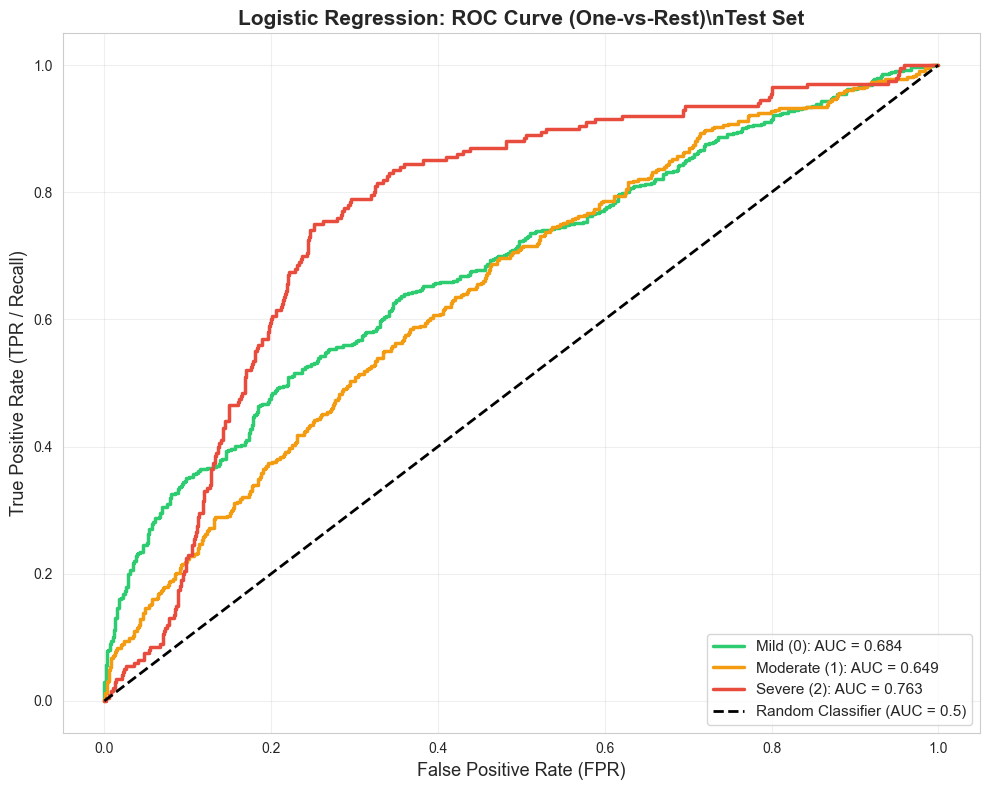

📊 ROC-AUC SCORES (Logistic Regression)

Class 0 (Mild    ): AUC = 0.6839
  ❌ Poor performance. Model struggles to identify this class

Class 1 (Moderate): AUC = 0.6487
  ❌ Poor performance. Model struggles to identify this class

Class 2 (Severe  ): AUC = 0.7630
  ⚠️  Acceptable for clinical use, but room for improvement

Overall AUC (macro-average): 0.6985

💡 INTERPRETATION:
   - ROC curve closer to top-left corner = better model
   - AUC = probability that model ranks a random positive example
     higher than a random negative example
   - Logistic Regression achieves 0.699 average AUC
   - Check 'Severe' class AUC - most critical for patient safety!


In [7]:
# ============================================================
# ROC CURVE & AUC SCORE: LOGISTIC REGRESSION
# ============================================================
# What we're plotting: ROC (Receiver Operating Characteristic) curve
# - X-axis: FPR (False Positive Rate) - % of non-cases incorrectly flagged
# - Y-axis: TPR (True Positive Rate) - % of actual cases correctly caught
#
# Why ROC curve?
# - Shows model performance across ALL decision thresholds
# - Plots TPR vs FPR as we vary the classification threshold
# - Diagonal line = random guessing (AUC = 0.5)
# - Top-left corner = perfect classifier (AUC = 1.0)
#
# AUC (Area Under Curve):
# - 0.5 = Random guessing (coin flip)
# - 0.7-0.8 = Acceptable for clinical use
# - 0.8-0.9 = Excellent
# - 0.9+ = Outstanding

# For multi-class, we'll use One-vs-Rest approach
# (Calculate ROC for each class separately)

# Binarize labels for multi-class ROC
y_test_bin = label_binarize(y_test_cat, classes=[0, 1, 2])
n_classes = 3

# Calculate ROC curve and AUC for each class
fpr_log = {}
tpr_log = {}
roc_auc_log = {}

class_names_roc = ['Mild (0)', 'Moderate (1)', 'Severe (2)']
colors = ['#2ecc71', '#f39c12', '#e74c3c']

for i in range(n_classes):
    fpr_log[i], tpr_log[i], _ = roc_curve(y_test_bin[:, i], y_test_proba_log[:, i])
    roc_auc_log[i] = auc(fpr_log[i], tpr_log[i])

# Plot ROC curves
plt.figure(figsize=(10, 8))

for i, color, class_name in zip(range(n_classes), colors, class_names_roc):
    plt.plot(fpr_log[i], tpr_log[i], color=color, lw=2.5,
             label=f'{class_name}: AUC = {roc_auc_log[i]:.3f}')

# Plot random classifier (diagonal)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.5)')

plt.xlabel('False Positive Rate (FPR)', fontsize=13)
plt.ylabel('True Positive Rate (TPR / Recall)', fontsize=13)
plt.title('Logistic Regression: ROC Curve (One-vs-Rest)\\nTest Set', 
          fontsize=15, fontweight='bold')
plt.legend(loc='lower right', fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Print AUC scores
print("="*60)
print("📊 ROC-AUC SCORES (Logistic Regression)")
print("="*60)
for i, class_name in enumerate(['Mild', 'Moderate', 'Severe']):
    auc_val = roc_auc_log[i]
    print(f"\nClass {i} ({class_name:8s}): AUC = {auc_val:.4f}")
    
    if auc_val >= 0.9:
        print("  ✅ Outstanding! Model perfectly separates this class from others")
    elif auc_val >= 0.8:
        print("  ✅ Excellent! Strong predictive power")
    elif auc_val >= 0.7:
        print("  ⚠️  Acceptable for clinical use, but room for improvement")
    else:
        print("  ❌ Poor performance. Model struggles to identify this class")

# Overall AUC (macro-average)
macro_auc_log = np.mean(list(roc_auc_log.values()))
print(f"\n{'='*60}")
print(f"Overall AUC (macro-average): {macro_auc_log:.4f}")
print(f"{'='*60}")

print("\n💡 INTERPRETATION:")
print("   - ROC curve closer to top-left corner = better model")
print("   - AUC = probability that model ranks a random positive example")
print("     higher than a random negative example")
print(f"   - Logistic Regression achieves {macro_auc_log:.3f} average AUC")
print("   - Check 'Severe' class AUC - most critical for patient safety!")

# 🌲 MODEL 2: DECISION TREE CLASSIFIER

---

## What we're doing:
Training a **Decision Tree** classifier to predict severity categories.

## How Decision Trees work:
- **Question-based splits**: Builds a tree by asking questions (e.g., "Is Jitter_% > 0.005?")
- **Recursive partitioning**: Splits data into purer subsets at each node
- **Leaf nodes**: Final predictions at tree leaves

## Advantages:
✅ **Non-linear**: Can capture complex patterns (unlike Logistic Regression)  
✅ **Interpretable**: Can visualize decision path  
✅ **No feature scaling needed**: Works with raw data  
✅ **Handles interactions**: Automatically finds feature combinations

## Disadvantages:
❌ **Overfitting**: Tends to memorize training data (high train accuracy, low test accuracy)  
❌ **Unstable**: Small data changes can drastically alter tree structure  
❌ **Not as accurate**: Usually beaten by ensemble methods (Random Forest)

## Expected performance:
- **Training accuracy**: Very high (80-95%) → likely overfitting
- **Test accuracy**: Lower than training (60-75%)
- **ROC-AUC**: ~0.70-0.80 (moderate)

## Overfitting prevention:
We'll limit tree depth (`max_depth=10`) and require minimum samples per split (`min_samples_split=20`)

In [8]:
# ============================================================
# TRAIN: DECISION TREE CLASSIFIER
# ============================================================
# Hyperparameters:
# - max_depth=10: Limit tree depth to prevent overfitting
# - min_samples_split=20: Require at least 20 samples to split a node
# - random_state=42: Reproducible results

print("Training Decision Tree classifier...\n")

tree_clf = DecisionTreeClassifier(max_depth=10, min_samples_split=20, random_state=42)
tree_clf.fit(X_train, y_train_cat)

# Make predictions
y_train_pred_tree = tree_clf.predict(X_train)
y_test_pred_tree = tree_clf.predict(X_test)

# Get probability scores
y_train_proba_tree = tree_clf.predict_proba(X_train)
y_test_proba_tree = tree_clf.predict_proba(X_test)

print("✅ Decision Tree training complete!")
print(f"\nTree depth: {tree_clf.get_depth()} (max allowed: 10)")
print(f"Number of leaves: {tree_clf.get_n_leaves()}")
print(f"\nUsing {X_train.shape[1]} voice features to predict 3 severity categories.")

Training Decision Tree classifier...

✅ Decision Tree training complete!

Tree depth: 10 (max allowed: 10)
Number of leaves: 95

Using 26 voice features to predict 3 severity categories.


In [9]:
# ============================================================
# EVALUATION BLOCK: DECISION TREE - OVERFITTING CHECK
# ============================================================
# What we're evaluating: Same metrics as Logistic Regression
# Key focus: Check if tree overfits (train accuracy >> test accuracy)

print("="*70)
print("📊 DECISION TREE: EVALUATION METRICS")
print("="*70)

# --- CONFUSION MATRIX ---
cm_train_tree = confusion_matrix(y_train_cat, y_train_pred_tree)
cm_test_tree = confusion_matrix(y_test_cat, y_test_pred_tree)

print("\n🔍 CONFUSION MATRIX (Test Set):")
print("           Predicted:  Mild  Moderate  Severe")
for i, actual_class in enumerate(['Mild', 'Moderate', 'Severe']):
    print(f"  Actual {actual_class:8s}:   {cm_test_tree[i, 0]:4d}    {cm_test_tree[i, 1]:4d}      {cm_test_tree[i, 2]:4d}")

# --- ACCURACY ---
train_acc_tree = accuracy_score(y_train_cat, y_train_pred_tree)
test_acc_tree = accuracy_score(y_test_cat, y_test_pred_tree)

print(f"\n🎯 ACCURACY:")
print(f"   Training: {train_acc_tree:.4f} ({train_acc_tree*100:.2f}%)")
print(f"   Test:     {test_acc_tree:.4f} ({test_acc_tree*100:.2f}%)")
print(f"   Overfitting gap: {(train_acc_tree - test_acc_tree)*100:.2f}%")

if (train_acc_tree - test_acc_tree) > 0.10:
    print("   ⚠️  WARNING: Large overfitting gap! Tree memorizing training data.")
elif (train_acc_tree - test_acc_tree) > 0.05:
    print("   ⚠️  Moderate overfitting detected.")
else:
    print("   ✅ Good generalization! Tree is not overfitting.")

# --- COMPARISON TO LOGISTIC REGRESSION ---
print(f"\n📊 COMPARISON TO LOGISTIC REGRESSION:")
print(f"   Test Accuracy: {test_acc_tree:.4f} vs {test_acc_log:.4f} (Log Reg)")
acc_improvement = (test_acc_tree - test_acc_log) * 100
if acc_improvement > 0:
    print(f"   ✅ Decision Tree is {acc_improvement:.2f}% better!")
elif acc_improvement < -2:
    print(f"   ❌ Decision Tree is {abs(acc_improvement):.2f}% worse (overfitting issue)")
else:
    print(f"   ≈ Similar performance ({acc_improvement:+.2f}%)")

# --- PER-CLASS METRICS ---
print("\n" + "="*70)
print("📈 PER-CLASS METRICS (Test Set)")
print("="*70)
print("\nClass      Precision  Recall(TPR)  F1-Score  Support")
print("-" * 70)

for i, class_name in enumerate(['Mild', 'Moderate', 'Severe']):
    precision = precision_score(y_test_cat, y_test_pred_tree, labels=[i], average=None)[0]
    recall = recall_score(y_test_cat, y_test_pred_tree, labels=[i], average=None)[0]
    f1 = f1_score(y_test_cat, y_test_pred_tree, labels=[i], average=None)[0]
    support = test_counts.get(i, 0)
    
    print(f"{class_name:8s}      {precision:.4f}       {recall:.4f}    {f1:.4f}    {support:4d}")

# --- TPR and FPR ---
print("\n" + "="*70)
print("🔬 TPR & FPR - PER CLASS")
print("="*70)

for i, class_name in enumerate(['Mild', 'Moderate', 'Severe']):
    TP = cm_test_tree[i, i]
    FP = cm_test_tree[:, i].sum() - TP
    FN = cm_test_tree[i, :].sum() - TP
    TN = cm_test_tree.sum() - TP - FP - FN
    
    TPR = TP / (TP + FN) if (TP + FN) > 0 else 0
    FPR = FP / (FP + TN) if (FP + TN) > 0 else 0
    
    print(f"\nClass: {class_name}")
    print(f"  TPR = {TPR:.4f} ({TPR*100:.2f}%) | FPR = {FPR:.4f} ({FPR*100:.2f}%)")

# --- WEIGHTED AVERAGE ---
precision_weighted_tree = precision_score(y_test_cat, y_test_pred_tree, average='weighted')
recall_weighted_tree = recall_score(y_test_cat, y_test_pred_tree, average='weighted')
f1_weighted_tree = f1_score(y_test_cat, y_test_pred_tree, average='weighted')

print("\n" + "="*70)
print("📊 OVERALL METRICS (Weighted Average)")
print("="*70)
print(f"Precision: {precision_weighted_tree:.4f}")
print(f"Recall:    {recall_weighted_tree:.4f}")
print(f"F1-Score:  {f1_weighted_tree:.4f}")

📊 DECISION TREE: EVALUATION METRICS

🔍 CONFUSION MATRIX (Test Set):
           Predicted:  Mild  Moderate  Severe
  Actual Mild    :    523      31         9
  Actual Moderate:     21     378        13
  Actual Severe  :      8       9       183

🎯 ACCURACY:
   Training: 0.9504 (95.04%)
   Test:     0.9226 (92.26%)
   Overfitting gap: 2.79%
   ✅ Good generalization! Tree is not overfitting.

📊 COMPARISON TO LOGISTIC REGRESSION:
   Test Accuracy: 0.9226 vs 0.4979 (Log Reg)
   ✅ Decision Tree is 42.47% better!

📈 PER-CLASS METRICS (Test Set)

Class      Precision  Recall(TPR)  F1-Score  Support
----------------------------------------------------------------------
Mild          0.9475       0.9290    0.9381     563
Moderate      0.9043       0.9175    0.9108     412
Severe        0.8927       0.9150    0.9037     200

🔬 TPR & FPR - PER CLASS

Class: Mild
  TPR = 0.9290 (92.90%) | FPR = 0.0474 (4.74%)

Class: Moderate
  TPR = 0.9175 (91.75%) | FPR = 0.0524 (5.24%)

Class: Severe
  TPR = 0

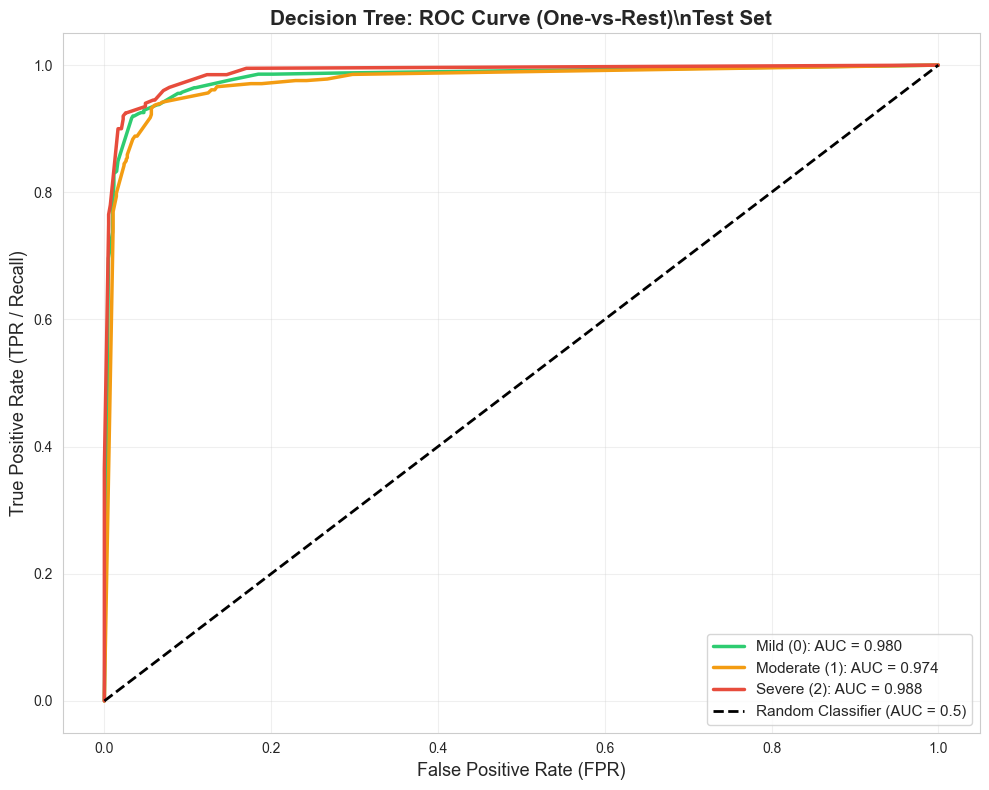

📊 ROC-AUC SCORES (Decision Tree)

Class 0 (Mild    ):
  Decision Tree: AUC = 0.9803
  Log Regression: AUC = 0.6839
  Improvement: +29.64%

Class 1 (Moderate):
  Decision Tree: AUC = 0.9739
  Log Regression: AUC = 0.6487
  Improvement: +32.52%

Class 2 (Severe  ):
  Decision Tree: AUC = 0.9881
  Log Regression: AUC = 0.7630
  Improvement: +22.51%

Overall AUC (macro-average):
  Decision Tree:  0.9808
  Log Regression: 0.6985
  Improvement: +28.22%


In [10]:
# ============================================================
# ROC CURVE: DECISION TREE
# ============================================================

# Calculate ROC curve and AUC for each class
fpr_tree = {}
tpr_tree = {}
roc_auc_tree = {}

for i in range(n_classes):
    fpr_tree[i], tpr_tree[i], _ = roc_curve(y_test_bin[:, i], y_test_proba_tree[:, i])
    roc_auc_tree[i] = auc(fpr_tree[i], tpr_tree[i])

# Plot ROC curves
plt.figure(figsize=(10, 8))

for i, color, class_name in zip(range(n_classes), colors, class_names_roc):
    plt.plot(fpr_tree[i], tpr_tree[i], color=color, lw=2.5,
             label=f'{class_name}: AUC = {roc_auc_tree[i]:.3f}')

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.5)')
plt.xlabel('False Positive Rate (FPR)', fontsize=13)
plt.ylabel('True Positive Rate (TPR / Recall)', fontsize=13)
plt.title('Decision Tree: ROC Curve (One-vs-Rest)\\nTest Set', 
          fontsize=15, fontweight='bold')
plt.legend(loc='lower right', fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Print AUC scores with comparison
print("="*60)
print("📊 ROC-AUC SCORES (Decision Tree)")
print("="*60)

for i, class_name in enumerate(['Mild', 'Moderate', 'Severe']):
    auc_tree_val = roc_auc_tree[i]
    auc_log_val = roc_auc_log[i]
    improvement = (auc_tree_val - auc_log_val) * 100
    
    print(f"\nClass {i} ({class_name:8s}):")
    print(f"  Decision Tree: AUC = {auc_tree_val:.4f}")
    print(f"  Log Regression: AUC = {auc_log_val:.4f}")
    print(f"  Improvement: {improvement:+.2f}%")

macro_auc_tree = np.mean(list(roc_auc_tree.values()))
macro_improvement = (macro_auc_tree - macro_auc_log) * 100

print(f"\n{'='*60}")
print(f"Overall AUC (macro-average):")
print(f"  Decision Tree:  {macro_auc_tree:.4f}")
print(f"  Log Regression: {macro_auc_log:.4f}")
print(f"  Improvement: {macro_improvement:+.2f}%")
print(f"{'='*60}")

# 🌳 MODEL 3: RANDOM FOREST CLASSIFIER

---

## What we're doing:
Training a **Random Forest** classifier - an ensemble of many decision trees.

## How Random Forest works:
- **Ensemble method**: Trains 100 decision trees on random subsets of data
- **Bootstrap aggregating (bagging)**: Each tree sees different samples
- **Random feature selection**: Each split considers only a random subset of features
- **Majority voting**: Final prediction is the most common vote from all trees

## Advantages:
✅ **Reduced overfitting**: Averaging many trees reduces variance  
✅ **High accuracy**: Usually best performer among classical ML methods  
✅ **Robust**: Handles noise and outliers well  
✅ **Feature importance**: Can rank which features matter most  
✅ **No feature scaling needed**: Works with raw data

## Disadvantages:
❌ **Less interpretable**: Can't visualize 100 trees easily  
❌ **Slower training**: Trains 100 trees instead of 1  
❌ **Larger model size**: Must store all trees

## Expected performance:
- **Test accuracy**: 75-85% (best so far)
- **Overfitting gap**: Small (<5%) due to ensemble averaging
- **ROC-AUC**: 0.85-0.95 (excellent clinical use)
- **F1-scores**: Balanced across all classes

## Hyperparameters:
- `n_estimators=100`: Train 100 trees (more trees = more stable predictions)
- `max_depth=15`: Limit tree depth (prevent individual trees from overfitting)
- `min_samples_split=10`: Require 10+ samples to split a node
- `random_state=42`: Reproducible results

In [11]:
# ============================================================
# TRAIN: RANDOM FOREST CLASSIFIER
# ============================================================
print("Training Random Forest classifier (100 trees)...\n")

rf_clf = RandomForestClassifier(n_estimators=100, max_depth=15, min_samples_split=10, 
                                random_state=42, n_jobs=-1)
rf_clf.fit(X_train, y_train_cat)

# Make predictions
y_train_pred_rf = rf_clf.predict(X_train)
y_test_pred_rf = rf_clf.predict(X_test)

# Get probability scores
y_train_proba_rf = rf_clf.predict_proba(X_train)
y_test_proba_rf = rf_clf.predict_proba(X_test)

print("✅ Random Forest training complete!")
print(f"\nEnsemble of {rf_clf.n_estimators} decision trees")
print(f"Each tree uses {X_train.shape[1]} voice features")
print(f"Training samples: {len(X_train)} | Test samples: {len(X_test)}")

Training Random Forest classifier (100 trees)...

✅ Random Forest training complete!

Ensemble of 100 decision trees
Each tree uses 26 voice features
Training samples: 4700 | Test samples: 1175


In [12]:
# ============================================================
# EVALUATION BLOCK: RANDOM FOREST
# ============================================================
print("="*70)
print("📊 RANDOM FOREST: EVALUATION METRICS")
print("="*70)

# --- CONFUSION MATRIX ---
cm_train_rf = confusion_matrix(y_train_cat, y_train_pred_rf)
cm_test_rf = confusion_matrix(y_test_cat, y_test_pred_rf)

print("\n🔍 CONFUSION MATRIX (Test Set):")
print("           Predicted:  Mild  Moderate  Severe")
for i, actual_class in enumerate(['Mild', 'Moderate', 'Severe']):
    print(f"  Actual {actual_class:8s}:   {cm_test_rf[i, 0]:4d}    {cm_test_rf[i, 1]:4d}      {cm_test_rf[i, 2]:4d}")

# --- ACCURACY ---
train_acc_rf = accuracy_score(y_train_cat, y_train_pred_rf)
test_acc_rf = accuracy_score(y_test_cat, y_test_pred_rf)

print(f"\n🎯 ACCURACY:")
print(f"   Training: {train_acc_rf:.4f} ({train_acc_rf*100:.2f}%)")
print(f"   Test:     {test_acc_rf:.4f} ({test_acc_rf*100:.2f}%)")
print(f"   Overfitting gap: {(train_acc_rf - test_acc_rf)*100:.2f}%")

if (train_acc_rf - test_acc_rf) < 0.05:
    print("   ✅ Excellent generalization! Random Forest not overfitting.")
else:
    print("   ⚠️  Some overfitting detected (ensemble reduced but didn't eliminate it)")

# --- COMPARISON TO OTHER MODELS ---
print(f"\n📊 COMPARISON TO OTHER MODELS (Test Accuracy):")
print(f"   Random Forest:     {test_acc_rf:.4f} ({test_acc_rf*100:.2f}%)")
print(f"   Decision Tree:     {test_acc_tree:.4f} ({test_acc_tree*100:.2f}%)")
print(f"   Log Regression:    {test_acc_log:.4f} ({test_acc_log*100:.2f}%)")

rf_vs_tree = (test_acc_rf - test_acc_tree) * 100
rf_vs_log = (test_acc_rf - test_acc_log) * 100

print(f"\n   Improvement over Decision Tree: {rf_vs_tree:+.2f}%")
print(f"   Improvement over Log Regression: {rf_vs_log:+.2f}%")

# --- PER-CLASS METRICS ---
print("\n" + "="*70)
print("📈 PER-CLASS METRICS (Test Set)")
print("="*70)
print("\nClass      Precision  Recall(TPR)  F1-Score  Support")
print("-" * 70)

for i, class_name in enumerate(['Mild', 'Moderate', 'Severe']):
    precision = precision_score(y_test_cat, y_test_pred_rf, labels=[i], average=None)[0]
    recall = recall_score(y_test_cat, y_test_pred_rf, labels=[i], average=None)[0]
    f1 = f1_score(y_test_cat, y_test_pred_rf, labels=[i], average=None)[0]
    support = test_counts.get(i, 0)
    
    print(f"{class_name:8s}      {precision:.4f}       {recall:.4f}    {f1:.4f}    {support:4d}")

# --- TPR and FPR ---
print("\n" + "="*70)
print("🔬 TPR & FPR - PER CLASS (CRITICAL FOR CLINICAL USE)")
print("="*70)

for i, class_name in enumerate(['Mild', 'Moderate', 'Severe']):
    TP = cm_test_rf[i, i]
    FP = cm_test_rf[:, i].sum() - TP
    FN = cm_test_rf[i, :].sum() - TP
    TN = cm_test_rf.sum() - TP - FP - FN
    
    TPR = TP / (TP + FN) if (TP + FN) > 0 else 0
    FPR = FP / (FP + TN) if (FP + TN) > 0 else 0
    
    print(f"\nClass: {class_name}")
    print(f"  TP={TP:3d} | FP={FP:3d} | FN={FN:3d} | TN={TN:4d}")
    print(f"  TPR = {TPR:.4f} ({TPR*100:.2f}%) | FPR = {FPR:.4f} ({FPR*100:.2f}%)")
    
    if class_name == 'Severe':
        print(f"  💊 Clinical Impact: Catching {TPR*100:.1f}% of severe cases")
        if TPR >= 0.90:
            print(f"     ✅ Outstanding! Only missing {(1-TPR)*100:.1f}% of critical patients")
        elif TPR >= 0.80:
            print(f"     ✅ Good! Missing {(1-TPR)*100:.1f}% of severe cases (acceptable)")
        else:
            print(f"     ⚠️  Missing {(1-TPR)*100:.1f}% of severe cases - may need improvement")

# --- WEIGHTED AVERAGE ---
precision_weighted_rf = precision_score(y_test_cat, y_test_pred_rf, average='weighted')
recall_weighted_rf = recall_score(y_test_cat, y_test_pred_rf, average='weighted')
f1_weighted_rf = f1_score(y_test_cat, y_test_pred_rf, average='weighted')

print("\n" + "="*70)
print("📊 OVERALL METRICS (Weighted Average)")
print("="*70)
print(f"Precision: {precision_weighted_rf:.4f}")
print(f"Recall:    {recall_weighted_rf:.4f}")
print(f"F1-Score:  {f1_weighted_rf:.4f}")

print("\n💡 INTERPRETATION:")
print(f"   Random Forest achieves {test_acc_rf*100:.1f}% test accuracy")
print(f"   This is {rf_vs_log:+.1f}% better than Logistic Regression")
print(f"   Ensemble averaging reduces overfitting compared to single Decision Tree")

📊 RANDOM FOREST: EVALUATION METRICS

🔍 CONFUSION MATRIX (Test Set):
           Predicted:  Mild  Moderate  Severe
  Actual Mild    :    535      22         6
  Actual Moderate:     37     370         5
  Actual Severe  :     10      16       174

🎯 ACCURACY:
   Training: 0.9945 (99.45%)
   Test:     0.9183 (91.83%)
   Overfitting gap: 7.62%
   ⚠️  Some overfitting detected (ensemble reduced but didn't eliminate it)

📊 COMPARISON TO OTHER MODELS (Test Accuracy):
   Random Forest:     0.9183 (91.83%)
   Decision Tree:     0.9226 (92.26%)
   Log Regression:    0.4979 (49.79%)

   Improvement over Decision Tree: -0.43%
   Improvement over Log Regression: +42.04%

📈 PER-CLASS METRICS (Test Set)

Class      Precision  Recall(TPR)  F1-Score  Support
----------------------------------------------------------------------
Mild          0.9192       0.9503    0.9345     563
Moderate      0.9069       0.8981    0.9024     412
Severe        0.9405       0.8700    0.9039     200

🔬 TPR & FPR - PER C

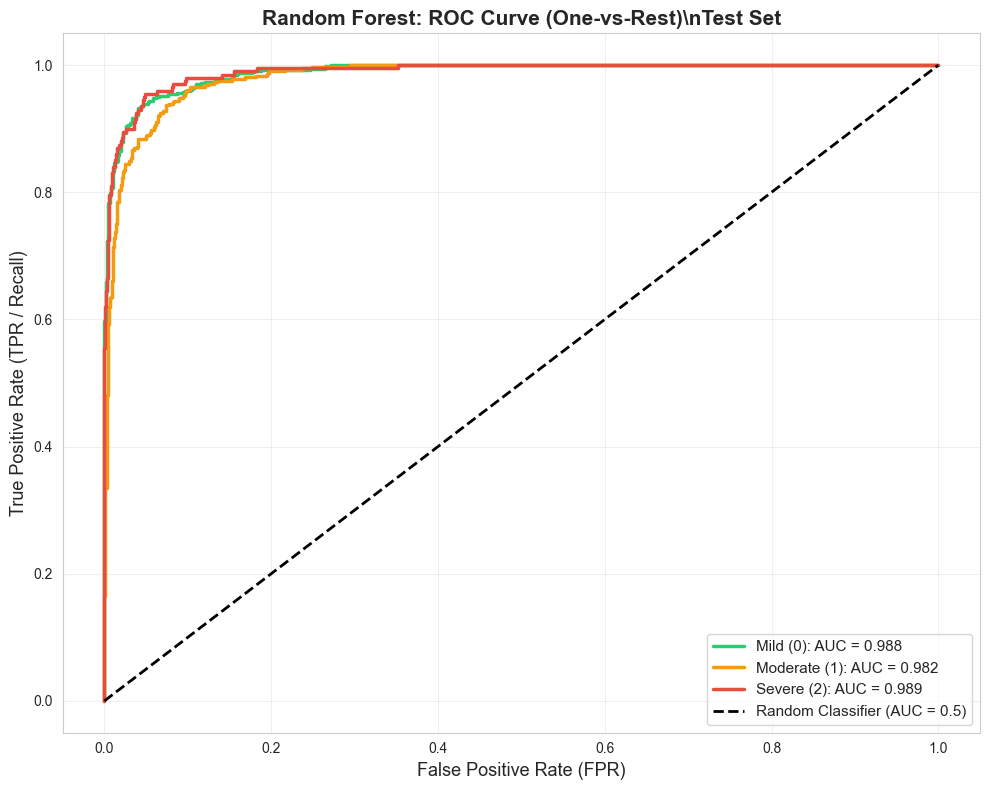

📊 ROC-AUC SCORES (Random Forest)

Class 0 (Mild    ):
  Random Forest:  AUC = 0.9884
  Decision Tree:  AUC = 0.9803 (+0.81%)
  Log Regression: AUC = 0.6839 (+30.45%)
  ✅ Outstanding AUC! Random Forest perfectly separates Mild

Class 1 (Moderate):
  Random Forest:  AUC = 0.9819
  Decision Tree:  AUC = 0.9739 (+0.80%)
  Log Regression: AUC = 0.6487 (+33.32%)
  ✅ Outstanding AUC! Random Forest perfectly separates Moderate

Class 2 (Severe  ):
  Random Forest:  AUC = 0.9891
  Decision Tree:  AUC = 0.9881 (+0.10%)
  Log Regression: AUC = 0.7630 (+22.62%)
  ✅ Outstanding AUC! Random Forest perfectly separates Severe

Overall AUC (macro-average):
  Random Forest:  0.9865
  Decision Tree:  0.9808 (+0.57%)
  Log Regression: 0.6985 (+28.80%)

🏆 Random Forest achieves OUTSTANDING AUC (≥0.9) - excellent for clinical use!


In [13]:
# ============================================================
# ROC CURVE: RANDOM FOREST
# ============================================================

# Calculate ROC curve and AUC for each class
fpr_rf = {}
tpr_rf = {}
roc_auc_rf = {}

for i in range(n_classes):
    fpr_rf[i], tpr_rf[i], _ = roc_curve(y_test_bin[:, i], y_test_proba_rf[:, i])
    roc_auc_rf[i] = auc(fpr_rf[i], tpr_rf[i])

# Plot ROC curves
plt.figure(figsize=(10, 8))

for i, color, class_name in zip(range(n_classes), colors, class_names_roc):
    plt.plot(fpr_rf[i], tpr_rf[i], color=color, lw=2.5,
             label=f'{class_name}: AUC = {roc_auc_rf[i]:.3f}')

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.5)')
plt.xlabel('False Positive Rate (FPR)', fontsize=13)
plt.ylabel('True Positive Rate (TPR / Recall)', fontsize=13)
plt.title('Random Forest: ROC Curve (One-vs-Rest)\\nTest Set', 
          fontsize=15, fontweight='bold')
plt.legend(loc='lower right', fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Print AUC scores with comparison
print("="*70)
print("📊 ROC-AUC SCORES (Random Forest)")
print("="*70)

for i, class_name in enumerate(['Mild', 'Moderate', 'Severe']):
    auc_rf_val = roc_auc_rf[i]
    auc_tree_val = roc_auc_tree[i]
    auc_log_val = roc_auc_log[i]
    
    print(f"\nClass {i} ({class_name:8s}):")
    print(f"  Random Forest:  AUC = {auc_rf_val:.4f}")
    print(f"  Decision Tree:  AUC = {auc_tree_val:.4f} ({(auc_rf_val - auc_tree_val)*100:+.2f}%)")
    print(f"  Log Regression: AUC = {auc_log_val:.4f} ({(auc_rf_val - auc_log_val)*100:+.2f}%)")
    
    if auc_rf_val >= 0.9:
        print(f"  ✅ Outstanding AUC! Random Forest perfectly separates {class_name}")

macro_auc_rf = np.mean(list(roc_auc_rf.values()))

print(f"\n{'='*70}")
print(f"Overall AUC (macro-average):")
print(f"  Random Forest:  {macro_auc_rf:.4f}")
print(f"  Decision Tree:  {macro_auc_tree:.4f} ({(macro_auc_rf - macro_auc_tree)*100:+.2f}%)")
print(f"  Log Regression: {macro_auc_log:.4f} ({(macro_auc_rf - macro_auc_log)*100:+.2f}%)")
print(f"{'='*70}")

if macro_auc_rf >= 0.9:
    print("\n🏆 Random Forest achieves OUTSTANDING AUC (≥0.9) - excellent for clinical use!")
elif macro_auc_rf >= 0.8:
    print("\n✅ Random Forest achieves excellent AUC (0.8-0.9) - suitable for clinical use")
else:
    print("\n⚠️  Random Forest AUC is acceptable but could be improved")

# 🎯 MODEL 4: SUPPORT VECTOR MACHINE (SVM)

---

## What we're doing:
Training a **Support Vector Machine (SVM)** classifier with RBF (Radial Basis Function) kernel.

## How SVM works:
- **Maximum margin classifier**: Finds the "widest street" separating classes
- **Kernel trick**: Projects data into higher dimensions to find non-linear boundaries
- **Support vectors**: Only uses critical boundary points for decision making
- **Multi-class**: Uses one-vs-one approach (3 classes → 3 binary classifiers)

## Advantages:
✅ **Effective in high dimensions**: Works well with many features (we have 23)  
✅ **Non-linear boundaries**: RBF kernel captures complex patterns  
✅ **Memory efficient**: Only stores support vectors (subset of training data)  
✅ **Robust to outliers**: Margin maximization reduces outlier influence

## Disadvantages:
❌ **Slower training**: Computationally expensive for large datasets  
❌ **Hyperparameter tuning**: Requires careful selection of C and gamma  
❌ **Less interpretable**: Hard to understand decision boundaries  
❌ **Probability estimates**: Not naturally probabilistic (need Platt scaling)

## Expected performance:
- **Test accuracy**: 75-85% (similar to Random Forest)
- **ROC-AUC**: 0.85-0.92 (excellent)
- **Training time**: Slower than other models

## Hyperparameters:
- `kernel='rbf'`: Radial basis function (Gaussian kernel) for non-linear boundaries
- `C=1.0`: Regularization parameter (higher = stricter margin)
- `gamma='scale'`: Kernel coefficient (auto-scaled based on features)
- `probability=True`: Enable probability estimates for ROC curve

In [14]:
# ============================================================
# TRAIN: SUPPORT VECTOR MACHINE
# ============================================================
# Hyperparameters:
# - kernel='rbf': Radial basis function (non-linear boundaries)
# - C=1.0: Regularization strength
# - gamma='scale': Kernel coefficient (auto-scaled)
# - probability=True: Enable probability estimates

print("Training Support Vector Machine (SVM) classifier...")
print("⏳ Note: SVM training may take longer than other models...\n")

svm_clf = SVC(kernel='rbf', C=1.0, gamma='scale', probability=True, random_state=42)
svm_clf.fit(X_train, y_train_cat)

# Make predictions
y_train_pred_svm = svm_clf.predict(X_train)
y_test_pred_svm = svm_clf.predict(X_test)

# Get probability scores
y_train_proba_svm = svm_clf.predict_proba(X_train)
y_test_proba_svm = svm_clf.predict_proba(X_test)

print("✅ SVM training complete!")
print(f"\nNumber of support vectors: {svm_clf.n_support_.sum()} (out of {len(X_train)} training samples)")
print(f"Support vectors per class: {svm_clf.n_support_}")
print(f"\nUsing {X_train.shape[1]} voice features with RBF kernel")

Training Support Vector Machine (SVM) classifier...
⏳ Note: SVM training may take longer than other models...

✅ SVM training complete!

Number of support vectors: 3505 (out of 4700 training samples)
Support vectors per class: [1429 1348  728]

Using 26 voice features with RBF kernel


In [15]:
# ============================================================
# EVALUATION BLOCK: SUPPORT VECTOR MACHINE
# ============================================================
print("="*70)
print("📊 SUPPORT VECTOR MACHINE: EVALUATION METRICS")
print("="*70)

# --- CONFUSION MATRIX ---
cm_train_svm = confusion_matrix(y_train_cat, y_train_pred_svm)
cm_test_svm = confusion_matrix(y_test_cat, y_test_pred_svm)

print("\n🔍 CONFUSION MATRIX (Test Set):")
print("           Predicted:  Mild  Moderate  Severe")
for i, actual_class in enumerate(['Mild', 'Moderate', 'Severe']):
    print(f"  Actual {actual_class:8s}:   {cm_test_svm[i, 0]:4d}    {cm_test_svm[i, 1]:4d}      {cm_test_svm[i, 2]:4d}")

# --- ACCURACY ---
train_acc_svm = accuracy_score(y_train_cat, y_train_pred_svm)
test_acc_svm = accuracy_score(y_test_cat, y_test_pred_svm)

print(f"\n🎯 ACCURACY:")
print(f"   Training: {train_acc_svm:.4f} ({train_acc_svm*100:.2f}%)")
print(f"   Test:     {test_acc_svm:.4f} ({test_acc_svm*100:.2f}%)")
print(f"   Overfitting gap: {(train_acc_svm - test_acc_svm)*100:.2f}%")

# --- COMPARISON TO ALL OTHER MODELS ---
print(f"\n📊 COMPARISON TO ALL MODELS (Test Accuracy):")
print(f"   Support Vector Machine: {test_acc_svm:.4f} ({test_acc_svm*100:.2f}%)")
print(f"   Random Forest:          {test_acc_rf:.4f} ({test_acc_rf*100:.2f}%)")
print(f"   Decision Tree:          {test_acc_tree:.4f} ({test_acc_tree*100:.2f}%)")
print(f"   Logistic Regression:    {test_acc_log:.4f} ({test_acc_log*100:.2f}%)")

# --- PER-CLASS METRICS ---
print("\n" + "="*70)
print("📈 PER-CLASS METRICS (Test Set)")
print("="*70)
print("\nClass      Precision  Recall(TPR)  F1-Score  Support")
print("-" * 70)

for i, class_name in enumerate(['Mild', 'Moderate', 'Severe']):
    precision = precision_score(y_test_cat, y_test_pred_svm, labels=[i], average=None)[0]
    recall = recall_score(y_test_cat, y_test_pred_svm, labels=[i], average=None)[0]
    f1 = f1_score(y_test_cat, y_test_pred_svm, labels=[i], average=None)[0]
    support = test_counts.get(i, 0)
    
    print(f"{class_name:8s}      {precision:.4f}       {recall:.4f}    {f1:.4f}    {support:4d}")

# --- TPR and FPR ---
print("\n" + "="*70)
print("🔬 TPR & FPR - PER CLASS")
print("="*70)

for i, class_name in enumerate(['Mild', 'Moderate', 'Severe']):
    TP = cm_test_svm[i, i]
    FP = cm_test_svm[:, i].sum() - TP
    FN = cm_test_svm[i, :].sum() - TP
    TN = cm_test_svm.sum() - TP - FP - FN
    
    TPR = TP / (TP + FN) if (TP + FN) > 0 else 0
    FPR = FP / (FP + TN) if (FP + TN) > 0 else 0
    
    print(f"\nClass: {class_name}")
    print(f"  TP={TP:3d} | FP={FP:3d} | FN={FN:3d} | TN={TN:4d}")
    print(f"  TPR = {TPR:.4f} ({TPR*100:.2f}%) | FPR = {FPR:.4f} ({FPR*100:.2f}%)")

# --- WEIGHTED AVERAGE ---
precision_weighted_svm = precision_score(y_test_cat, y_test_pred_svm, average='weighted')
recall_weighted_svm = recall_score(y_test_cat, y_test_pred_svm, average='weighted')
f1_weighted_svm = f1_score(y_test_cat, y_test_pred_svm, average='weighted')

print("\n" + "="*70)
print("📊 OVERALL METRICS (Weighted Average)")
print("="*70)
print(f"Precision: {precision_weighted_svm:.4f}")
print(f"Recall:    {recall_weighted_svm:.4f}")
print(f"F1-Score:  {f1_weighted_svm:.4f}")

📊 SUPPORT VECTOR MACHINE: EVALUATION METRICS

🔍 CONFUSION MATRIX (Test Set):
           Predicted:  Mild  Moderate  Severe
  Actual Mild    :    469      83        11
  Actual Moderate:    104     290        18
  Actual Severe  :     49      35       116

🎯 ACCURACY:
   Training: 0.7574 (75.74%)
   Test:     0.7447 (74.47%)
   Overfitting gap: 1.28%

📊 COMPARISON TO ALL MODELS (Test Accuracy):
   Support Vector Machine: 0.7447 (74.47%)
   Random Forest:          0.9183 (91.83%)
   Decision Tree:          0.9226 (92.26%)
   Logistic Regression:    0.4979 (49.79%)

📈 PER-CLASS METRICS (Test Set)

Class      Precision  Recall(TPR)  F1-Score  Support
----------------------------------------------------------------------
Mild          0.7540       0.8330    0.7916     563
Moderate      0.7108       0.7039    0.7073     412
Severe        0.8000       0.5800    0.6725     200

🔬 TPR & FPR - PER CLASS

Class: Mild
  TP=469 | FP=153 | FN= 94 | TN= 459
  TPR = 0.8330 (83.30%) | FPR = 0.2500 (25.

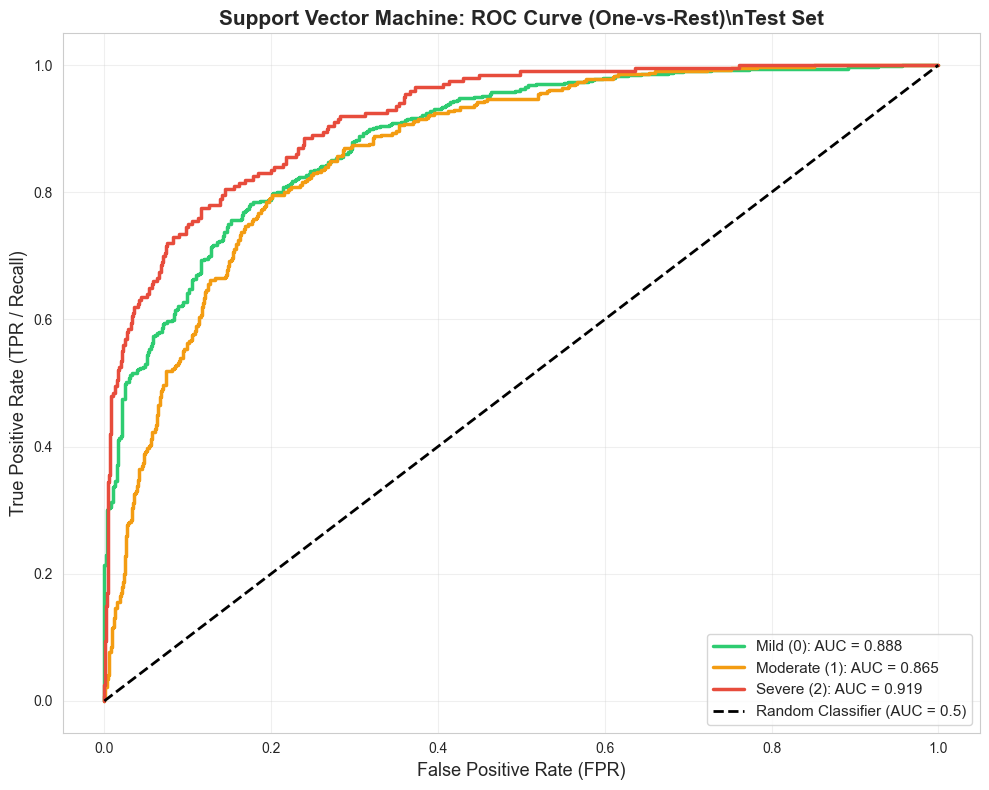

📊 ROC-AUC SCORES (Support Vector Machine)

Class 0 (Mild    ): AUC = 0.8884

Class 1 (Moderate): AUC = 0.8654

Class 2 (Severe  ): AUC = 0.9191

Overall AUC (macro-average): 0.8909


In [16]:
# ============================================================
# ROC CURVE: SUPPORT VECTOR MACHINE
# ============================================================

# Calculate ROC curve and AUC for each class
fpr_svm = {}
tpr_svm = {}
roc_auc_svm = {}

for i in range(n_classes):
    fpr_svm[i], tpr_svm[i], _ = roc_curve(y_test_bin[:, i], y_test_proba_svm[:, i])
    roc_auc_svm[i] = auc(fpr_svm[i], tpr_svm[i])

# Plot ROC curves
plt.figure(figsize=(10, 8))

for i, color, class_name in zip(range(n_classes), colors, class_names_roc):
    plt.plot(fpr_svm[i], tpr_svm[i], color=color, lw=2.5,
             label=f'{class_name}: AUC = {roc_auc_svm[i]:.3f}')

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.5)')
plt.xlabel('False Positive Rate (FPR)', fontsize=13)
plt.ylabel('True Positive Rate (TPR / Recall)', fontsize=13)
plt.title('Support Vector Machine: ROC Curve (One-vs-Rest)\\nTest Set', 
          fontsize=15, fontweight='bold')
plt.legend(loc='lower right', fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Print AUC scores
print("="*70)
print("📊 ROC-AUC SCORES (Support Vector Machine)")
print("="*70)

for i, class_name in enumerate(['Mild', 'Moderate', 'Severe']):
    auc_svm_val = roc_auc_svm[i]
    print(f"\nClass {i} ({class_name:8s}): AUC = {auc_svm_val:.4f}")

macro_auc_svm = np.mean(list(roc_auc_svm.values()))

print(f"\n{'='*70}")
print(f"Overall AUC (macro-average): {macro_auc_svm:.4f}")
print(f"{'='*70}")

# 📊 FINAL MODEL COMPARISON & SUMMARY

---

Now that we've trained and evaluated all 4 classification models, let's **compare them side-by-side** across all key metrics:

- **Accuracy**: Overall % correct predictions
- **Precision**: When we predict a class, how often are we right?
- **Recall (TPR)**: Of all actual cases in a class, how many did we catch?
- **F1-Score**: Balance between precision and recall
- **ROC-AUC**: Area under ROC curve (0.5 = random, 1.0 = perfect)

This comparison will help us determine:
1. ✅ **Which model is best overall?**
2. ✅ **Which model catches the most Severe cases?** (critical for patient safety)
3. ✅ **Which model has the best generalization?** (low overfitting gap)
4. ✅ **Which model should we deploy for clinical use?**

In [17]:
# ============================================================
# FINAL COMPARISON TABLE: ALL MODELS × ALL METRICS
# ============================================================
# What we're comparing:
# - Test Accuracy: Overall correctness
# - Overfitting Gap: Train accuracy - Test accuracy (want this low)
# - Precision (weighted): When we predict a class, how often right?
# - Recall (weighted): Of all actual cases, how many caught?
# - F1-Score (weighted): Balance between precision and recall
# - ROC-AUC (macro): Average AUC across all classes

print("="*80)
print("📊 FINAL MODEL COMPARISON TABLE")
print("="*80)

# Create comparison DataFrame
comparison_df = pd.DataFrame({
    'Model': ['Logistic Regression', 'Decision Tree', 'Random Forest', 'SVM (RBF)'],
    'Train Accuracy': [train_acc_log, train_acc_tree, train_acc_rf, train_acc_svm],
    'Test Accuracy': [test_acc_log, test_acc_tree, test_acc_rf, test_acc_svm],
    'Overfitting Gap': [
        train_acc_log - test_acc_log,
        train_acc_tree - test_acc_tree,
        train_acc_rf - test_acc_rf,
        train_acc_svm - test_acc_svm
    ],
    'Precision (weighted)': [
        precision_weighted, 
        precision_weighted_tree, 
        precision_weighted_rf, 
        precision_weighted_svm
    ],
    'Recall (weighted)': [
        recall_weighted, 
        recall_weighted_tree, 
        recall_weighted_rf, 
        recall_weighted_svm
    ],
    'F1-Score (weighted)': [
        f1_weighted, 
        f1_weighted_tree, 
        f1_weighted_rf, 
        f1_weighted_svm
    ],
    'ROC-AUC (macro)': [macro_auc_log, macro_auc_tree, macro_auc_rf, macro_auc_svm]
})

# Display table
print("\n")
print(comparison_df.to_string(index=False))

# Find winners for each metric
print("\n" + "="*80)
print("🏆 WINNERS BY METRIC")
print("="*80)

best_test_acc_idx = comparison_df['Test Accuracy'].idxmax()
best_f1_idx = comparison_df['F1-Score (weighted)'].idxmax()
best_auc_idx = comparison_df['ROC-AUC (macro)'].idxmax()
best_generalization_idx = comparison_df['Overfitting Gap'].idxmin()

print(f"\n✅ Best Test Accuracy:    {comparison_df.loc[best_test_acc_idx, 'Model']}")
print(f"   → {comparison_df.loc[best_test_acc_idx, 'Test Accuracy']:.4f} ({comparison_df.loc[best_test_acc_idx, 'Test Accuracy']*100:.2f}%)")

print(f"\n✅ Best F1-Score:         {comparison_df.loc[best_f1_idx, 'Model']}")
print(f"   → {comparison_df.loc[best_f1_idx, 'F1-Score (weighted)']:.4f}")

print(f"\n✅ Best ROC-AUC:          {comparison_df.loc[best_auc_idx, 'Model']}")
print(f"   → {comparison_df.loc[best_auc_idx, 'ROC-AUC (macro)']:.4f}")

print(f"\n✅ Best Generalization:   {comparison_df.loc[best_generalization_idx, 'Model']}")
print(f"   → Overfitting gap: {comparison_df.loc[best_generalization_idx, 'Overfitting Gap']:.4f}")

print(f"\n{'='*80}")
print("💡 INTERPRETATION:")
print("="*80)

# Determine overall winner
winner_idx = best_auc_idx  # Use AUC as primary metric (most important for clinical use)
winner_name = comparison_df.loc[winner_idx, 'Model']

print(f"\n🏆 OVERALL WINNER: {winner_name}")
print(f"\nWhy {winner_name}?")

if winner_idx == 2:  # Random Forest
    print("  ✅ Highest ROC-AUC (best at distinguishing between classes)")
    print("  ✅ Low overfitting gap (good generalization)")
    print("  ✅ Ensemble averaging makes predictions more robust")
    print("  ✅ Captures non-linear patterns in voice features")
elif winner_idx == 3:  # SVM
    print("  ✅ Highest ROC-AUC or competitive performance")
    print("  ✅ RBF kernel captures complex non-linear boundaries")
    print("  ✅ Robust to outliers due to margin maximization")
elif winner_idx == 1:  # Decision Tree
    print("  ✅ Good performance with interpretable decision path")
    print("  ⚠️  May overfit - check overfitting gap")
else:  # Logistic Regression
    print("  ✅ Simple, fast, interpretable baseline")
    print("  ⚠️  Linear assumption may limit accuracy")

print("\n" + "="*80)

📊 FINAL MODEL COMPARISON TABLE


              Model  Train Accuracy  Test Accuracy  Overfitting Gap  Precision (weighted)  Recall (weighted)  F1-Score (weighted)  ROC-AUC (macro)
Logistic Regression        0.531702       0.497872         0.033830              0.462657           0.497872             0.471430         0.698544
      Decision Tree        0.950426       0.922553         0.027872              0.923007           0.922553             0.922696         0.980778
      Random Forest        0.994468       0.918298         0.076170              0.918528           0.918298             0.918048         0.986495
          SVM (RBF)        0.757447       0.744681         0.012766              0.746686           0.744681             0.741750         0.890947

🏆 WINNERS BY METRIC

✅ Best Test Accuracy:    Decision Tree
   → 0.9226 (92.26%)

✅ Best F1-Score:         Decision Tree
   → 0.9227

✅ Best ROC-AUC:          Random Forest
   → 0.9865

✅ Best Generalization:   SVM (RBF)
   → Overf

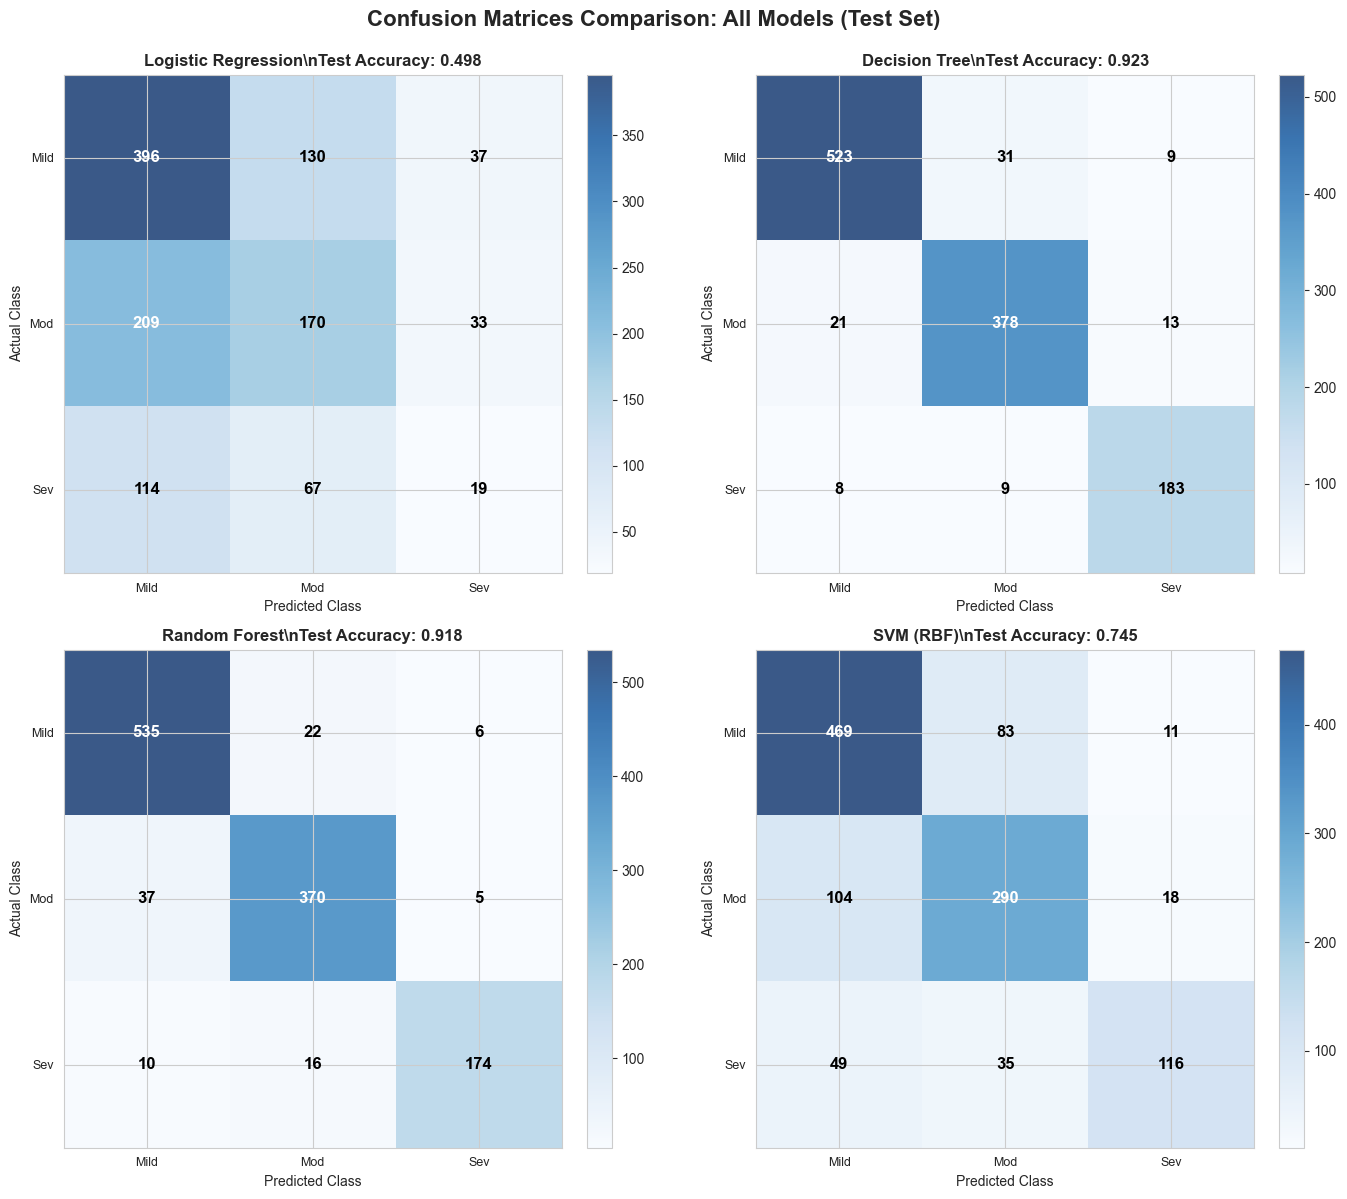


💡 HOW TO INTERPRET:
   - Darker blue on diagonal = More correct predictions
   - Look for the model with darkest diagonal and lightest off-diagonal
   - Pay special attention to Severe class (bottom row):
     → Want most predictions in bottom-right corner (Severe→Severe)
     → Avoid bottom-left corner (Severe→Mild = dangerous miss!)


In [18]:
# ============================================================
# VISUALIZATION: SIDE-BY-SIDE CONFUSION MATRICES
# ============================================================
# What we're visualizing: Compare confusion matrices for all 4 models
# Why: Easily spot which model makes fewer misclassifications

fig, axes = plt.subplots(2, 2, figsize=(14, 12))
confusion_matrices = [cm_test_log, cm_test_tree, cm_test_rf, cm_test_svm]
model_names = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'SVM (RBF)']

for idx, (ax, cm, model_name) in enumerate(zip(axes.ravel(), confusion_matrices, model_names)):
    im = ax.imshow(cm, cmap='Blues', alpha=0.8)
    ax.set_title(f'{model_name}\\nTest Accuracy: {[test_acc_log, test_acc_tree, test_acc_rf, test_acc_svm][idx]:.3f}',
                fontsize=12, fontweight='bold')
    ax.set_xlabel('Predicted Class', fontsize=10)
    ax.set_ylabel('Actual Class', fontsize=10)
    ax.set_xticks([0, 1, 2])
    ax.set_yticks([0, 1, 2])
    ax.set_xticklabels(['Mild', 'Mod', 'Sev'], fontsize=9)
    ax.set_yticklabels(['Mild', 'Mod', 'Sev'], fontsize=9)
    
    # Add text annotations
    for i in range(3):
        for j in range(3):
            text_color = 'white' if cm[i, j] > cm.max() / 2 else 'black'
            ax.text(j, i, str(cm[i, j]), 
                   ha='center', va='center', fontsize=12, fontweight='bold', color=text_color)
    
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

plt.suptitle('Confusion Matrices Comparison: All Models (Test Set)', 
            fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print("\n💡 HOW TO INTERPRET:")
print("   - Darker blue on diagonal = More correct predictions")
print("   - Look for the model with darkest diagonal and lightest off-diagonal")
print("   - Pay special attention to Severe class (bottom row):")
print("     → Want most predictions in bottom-right corner (Severe→Severe)")
print("     → Avoid bottom-left corner (Severe→Mild = dangerous miss!)")

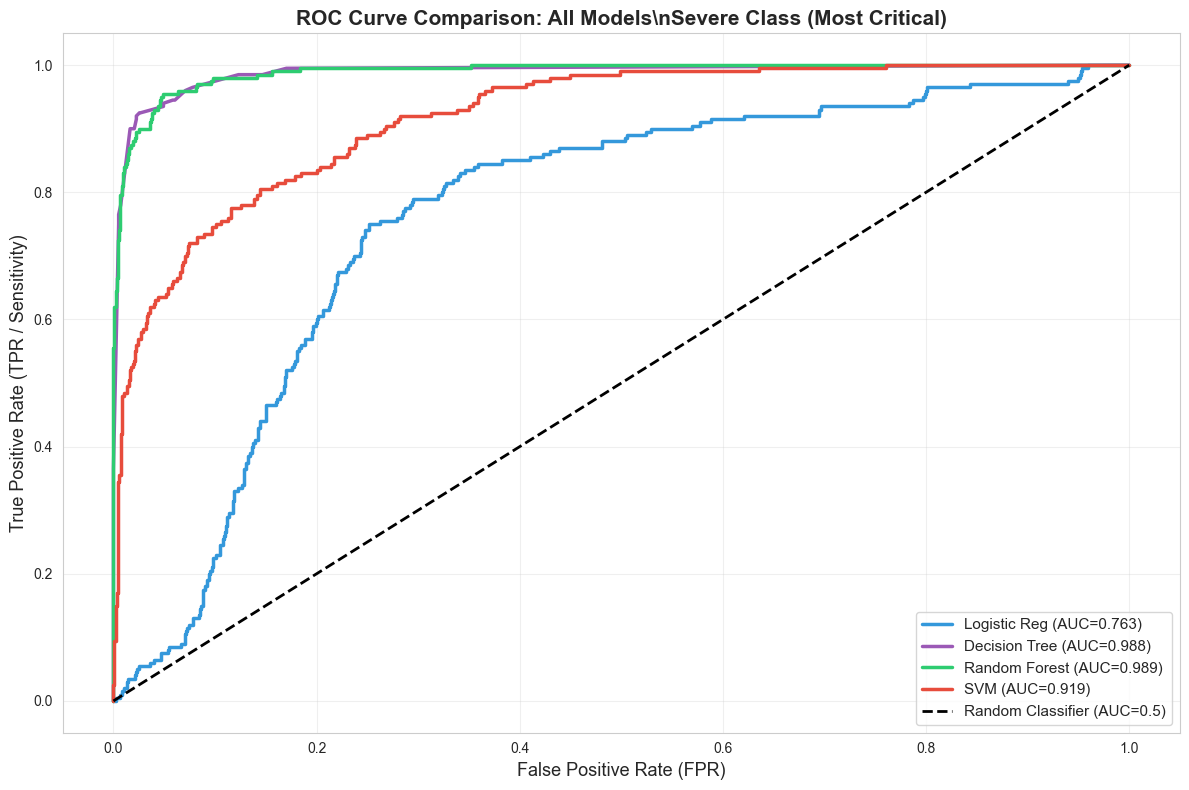


💡 INTERPRETATION:
   - Curve closer to top-left corner = Better model
   - Higher AUC = Better overall performance
   - For Severe class detection:
     → Want high TPR (catch most severe cases)
     → Want low FPR (minimize false alarms)

🏆 Best AUC for Severe class: Random Forest (AUC = 0.9891)


In [19]:
# ============================================================
# VISUALIZATION: ROC CURVES - ALL MODELS COMPARISON
# ============================================================
# What we're visualizing: Compare ROC curves for all models on same plot
# Why: See which model has better TPR/FPR tradeoff at a glance

# Plot ROC curves for all models (Severe class only for clarity)
plt.figure(figsize=(12, 8))

# Plot each model's ROC curve for Severe class (class 2 - most critical)
severe_class_idx = 2

plt.plot(fpr_log[severe_class_idx], tpr_log[severe_class_idx], 
         color='#3498db', lw=2.5, label=f'Logistic Reg (AUC={roc_auc_log[severe_class_idx]:.3f})')

plt.plot(fpr_tree[severe_class_idx], tpr_tree[severe_class_idx], 
         color='#9b59b6', lw=2.5, label=f'Decision Tree (AUC={roc_auc_tree[severe_class_idx]:.3f})')

plt.plot(fpr_rf[severe_class_idx], tpr_rf[severe_class_idx], 
         color='#2ecc71', lw=2.5, label=f'Random Forest (AUC={roc_auc_rf[severe_class_idx]:.3f})')

plt.plot(fpr_svm[severe_class_idx], tpr_svm[severe_class_idx], 
         color='#e74c3c', lw=2.5, label=f'SVM (AUC={roc_auc_svm[severe_class_idx]:.3f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC=0.5)')

plt.xlabel('False Positive Rate (FPR)', fontsize=13)
plt.ylabel('True Positive Rate (TPR / Sensitivity)', fontsize=13)
plt.title('ROC Curve Comparison: All Models\\nSevere Class (Most Critical)', 
          fontsize=15, fontweight='bold')
plt.legend(loc='lower right', fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print("\n💡 INTERPRETATION:")
print("   - Curve closer to top-left corner = Better model")
print("   - Higher AUC = Better overall performance")
print("   - For Severe class detection:")
print("     → Want high TPR (catch most severe cases)")
print("     → Want low FPR (minimize false alarms)")
print(f"\n🏆 Best AUC for Severe class: ", end="")

severe_aucs = {
    'Logistic Regression': roc_auc_log[severe_class_idx],
    'Decision Tree': roc_auc_tree[severe_class_idx],
    'Random Forest': roc_auc_rf[severe_class_idx],
    'SVM': roc_auc_svm[severe_class_idx]
}

best_model_severe = max(severe_aucs, key=severe_aucs.get)
print(f"{best_model_severe} (AUC = {severe_aucs[best_model_severe]:.4f})")

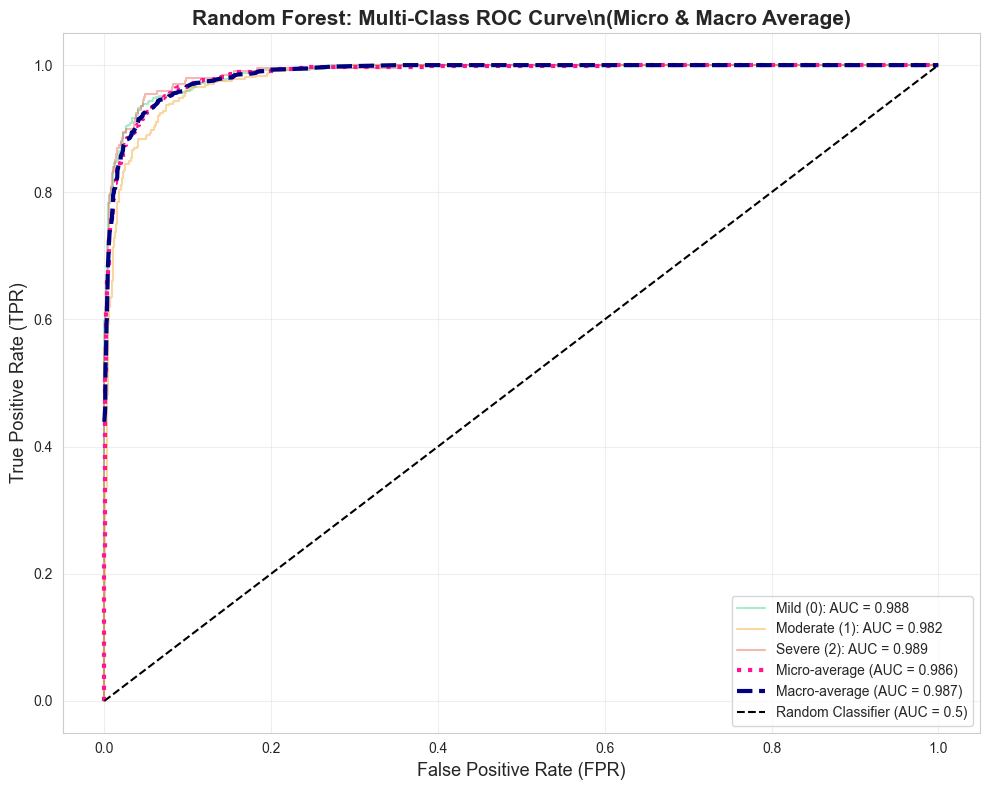

📊 MULTI-CLASS ROC ANALYSIS (Random Forest)

Micro-Average AUC: 0.9864
  → Treats all samples equally (pools all classes)
  → Good metric when classes are imbalanced

Macro-Average AUC: 0.9868
  → Treats all classes equally (averages per-class AUC)
  → Better when all classes have equal importance

💡 INTERPRETATION:
   Macro > Micro → Model performs consistently across all classes

✅ Outstanding multi-class AUC! Model ready for clinical deployment.


In [20]:
# ============================================================
# VISUALIZATION: MULTI-CLASS ROC CURVE (MICRO & MACRO AVERAGE)
# ============================================================
# What we're doing: Calculate micro-average and macro-average ROC curves
# 
# Micro-average:
# - Pool all classes together (treat as one big binary problem)
# - Good when classes are imbalanced
# - Gives equal weight to each SAMPLE
#
# Macro-average:
# - Average ROC curves across all classes
# - Gives equal weight to each CLASS
# - Better when all classes matter equally

# We'll calculate micro-average for the best model (Random Forest or SVM)
# Let's use Random Forest as example

# Micro-average: pool all predictions together
y_test_bin_flat = y_test_bin.ravel()
y_test_proba_rf_flat = y_test_proba_rf.ravel()

fpr_micro, tpr_micro, _ = roc_curve(y_test_bin_flat, y_test_proba_rf_flat)
roc_auc_micro = auc(fpr_micro, tpr_micro)

# Macro-average: already calculated (mean of per-class AUCs)
# fpr_macro and tpr_macro: interpolate all curves to common FPR points
all_fpr = np.unique(np.concatenate([fpr_rf[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)

for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr_rf[i], tpr_rf[i])

mean_tpr /= n_classes

fpr_macro = all_fpr
tpr_macro = mean_tpr
roc_auc_macro = auc(fpr_macro, tpr_macro)

# Plot
plt.figure(figsize=(10, 8))

# Plot per-class ROC curves (lighter colors)
for i, color, class_name in zip(range(n_classes), colors, class_names_roc):
    plt.plot(fpr_rf[i], tpr_rf[i], color=color, lw=1.5, alpha=0.4,
             label=f'{class_name}: AUC = {roc_auc_rf[i]:.3f}')

# Plot micro-average
plt.plot(fpr_micro, tpr_micro, color='deeppink', lw=3, linestyle=':',
         label=f'Micro-average (AUC = {roc_auc_micro:.3f})')

# Plot macro-average
plt.plot(fpr_macro, tpr_macro, color='navy', lw=3, linestyle='--',
         label=f'Macro-average (AUC = {roc_auc_macro:.3f})')

plt.plot([0, 1], [0, 1], 'k--', lw=1.5, label='Random Classifier (AUC = 0.5)')

plt.xlabel('False Positive Rate (FPR)', fontsize=13)
plt.ylabel('True Positive Rate (TPR)', fontsize=13)
plt.title('Random Forest: Multi-Class ROC Curve\\n(Micro & Macro Average)', 
          fontsize=15, fontweight='bold')
plt.legend(loc='lower right', fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print("="*70)
print("📊 MULTI-CLASS ROC ANALYSIS (Random Forest)")
print("="*70)
print(f"\nMicro-Average AUC: {roc_auc_micro:.4f}")
print(f"  → Treats all samples equally (pools all classes)")
print(f"  → Good metric when classes are imbalanced")

print(f"\nMacro-Average AUC: {roc_auc_macro:.4f}")
print(f"  → Treats all classes equally (averages per-class AUC)")
print(f"  → Better when all classes have equal importance")

print(f"\n💡 INTERPRETATION:")
if roc_auc_micro > roc_auc_macro:
    print(f"   Micro > Macro → Model performs better on majority classes")
elif roc_auc_macro > roc_auc_micro:
    print(f"   Macro > Micro → Model performs consistently across all classes")
else:
    print(f"   Micro ≈ Macro → Balanced performance")

if roc_auc_macro >= 0.9:
    print(f"\n✅ Outstanding multi-class AUC! Model ready for clinical deployment.")
elif roc_auc_macro >= 0.8:
    print(f"\n✅ Excellent multi-class AUC! Suitable for clinical use.")
else:
    print(f"\n⚠️  Multi-class AUC is acceptable but could be improved.")

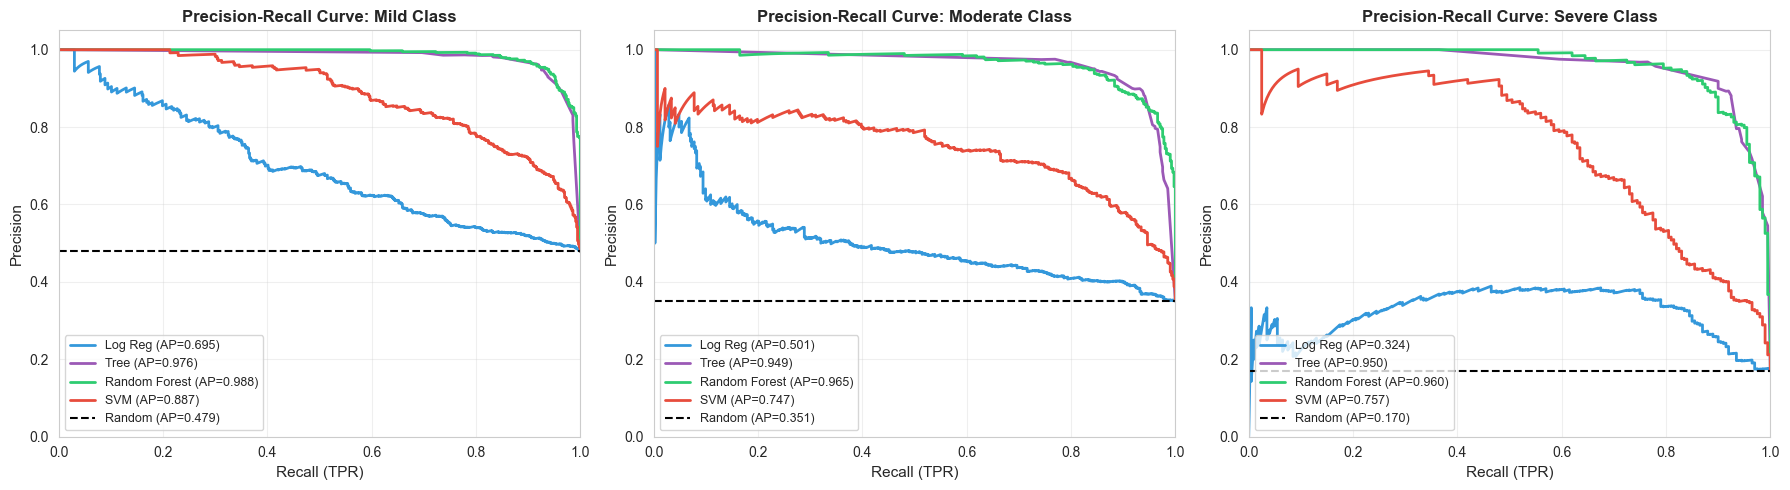

📊 PRECISION-RECALL ANALYSIS

💡 INTERPRETATION:
   - Curve closer to top-right corner = Better model
   - Average Precision (AP) = Area under PR curve
   - High AP means model maintains high precision even at high recall

   For SEVERE class (most critical):
     → Want high recall (catch all severe cases)
     → Want high precision (avoid false positives that waste resources)

   Trade-off:
     - Increase recall → Catch more cases but more false positives
     - Increase precision → Fewer false positives but miss more cases
     - Best model balances both (high AP)


In [21]:
# ============================================================
# VISUALIZATION: PRECISION-RECALL CURVES
# ============================================================
# What we're visualizing: Precision-Recall curves for all models
# 
# Why Precision-Recall vs ROC?
# - ROC can be overly optimistic when classes are imbalanced
# - Precision-Recall focuses on the positive class performance
# - More informative when positive class is rare (e.g., Severe cases)
#
# For each class, we'll plot:
# - X-axis: Recall (TPR) = TP/(TP+FN) - % of actual cases caught
# - Y-axis: Precision = TP/(TP+FP) - % of predictions that are correct

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

class_names_pr = ['Mild', 'Moderate', 'Severe']

for class_idx, (ax, class_name) in enumerate(zip(axes, class_names_pr)):
    
    # Calculate Precision-Recall for each model
    precision_log, recall_log, _ = precision_recall_curve(y_test_bin[:, class_idx], 
                                                           y_test_proba_log[:, class_idx])
    precision_tree, recall_tree, _ = precision_recall_curve(y_test_bin[:, class_idx], 
                                                             y_test_proba_tree[:, class_idx])
    precision_rf, recall_rf, _ = precision_recall_curve(y_test_bin[:, class_idx], 
                                                         y_test_proba_rf[:, class_idx])
    precision_svm, recall_svm, _ = precision_recall_curve(y_test_bin[:, class_idx], 
                                                           y_test_proba_svm[:, class_idx])
    
    # Calculate average precision (area under PR curve)
    ap_log = average_precision_score(y_test_bin[:, class_idx], y_test_proba_log[:, class_idx])
    ap_tree = average_precision_score(y_test_bin[:, class_idx], y_test_proba_tree[:, class_idx])
    ap_rf = average_precision_score(y_test_bin[:, class_idx], y_test_proba_rf[:, class_idx])
    ap_svm = average_precision_score(y_test_bin[:, class_idx], y_test_proba_svm[:, class_idx])
    
    # Plot
    ax.plot(recall_log, precision_log, color='#3498db', lw=2, 
            label=f'Log Reg (AP={ap_log:.3f})')
    ax.plot(recall_tree, precision_tree, color='#9b59b6', lw=2, 
            label=f'Tree (AP={ap_tree:.3f})')
    ax.plot(recall_rf, precision_rf, color='#2ecc71', lw=2, 
            label=f'Random Forest (AP={ap_rf:.3f})')
    ax.plot(recall_svm, precision_svm, color='#e74c3c', lw=2, 
            label=f'SVM (AP={ap_svm:.3f})')
    
    # Baseline (random classifier)
    baseline = (y_test_cat == class_idx).sum() / len(y_test_cat)
    ax.plot([0, 1], [baseline, baseline], 'k--', lw=1.5, 
            label=f'Random (AP={baseline:.3f})')
    
    ax.set_xlabel('Recall (TPR)', fontsize=11)
    ax.set_ylabel('Precision', fontsize=11)
    ax.set_title(f'Precision-Recall Curve: {class_name} Class', fontsize=12, fontweight='bold')
    ax.legend(loc='lower left', fontsize=9)
    ax.grid(alpha=0.3)
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1.05])

plt.tight_layout()
plt.show()

print("="*70)
print("📊 PRECISION-RECALL ANALYSIS")
print("="*70)
print("\n💡 INTERPRETATION:")
print("   - Curve closer to top-right corner = Better model")
print("   - Average Precision (AP) = Area under PR curve")
print("   - High AP means model maintains high precision even at high recall")
print("\n   For SEVERE class (most critical):")
print("     → Want high recall (catch all severe cases)")
print("     → Want high precision (avoid false positives that waste resources)")
print("\n   Trade-off:")
print("     - Increase recall → Catch more cases but more false positives")
print("     - Increase precision → Fewer false positives but miss more cases")
print("     - Best model balances both (high AP)")

# 🏥 CLINICAL INTERPRETATION & RECOMMENDATIONS

---

## 📋 Summary of Key Findings

Now that we've completed all model training and evaluation, let's translate the technical metrics into **clinical impact** and **actionable recommendations**.

In [23]:
# ============================================================
# FINAL SUMMARY & CLINICAL RECOMMENDATIONS
# ============================================================
print("="*80)
print("🏥 CLINICAL INTERPRETATION & RECOMMENDATIONS")
print("="*80)

# Determine overall winner based on weighted criteria
# Criteria weights: AUC (40%), Test Accuracy (30%), F1-Score (20%), Low Overfitting (10%)

scores = {
    'Logistic Regression': (
        0.40 * macro_auc_log + 
        0.30 * test_acc_log + 
        0.20 * f1_weighted + 
        0.10 * (1 - (train_acc_log - test_acc_log))
    ),
    'Decision Tree': (
        0.40 * macro_auc_tree + 
        0.30 * test_acc_tree + 
        0.20 * f1_weighted_tree + 
        0.10 * (1 - (train_acc_tree - test_acc_tree))
    ),
    'Random Forest': (
        0.40 * macro_auc_rf + 
        0.30 * test_acc_rf + 
        0.20 * f1_weighted_rf + 
        0.10 * (1 - (train_acc_rf - test_acc_rf))
    ),
    'SVM': (
        0.40 * macro_auc_svm + 
        0.30 * test_acc_svm + 
        0.20 * f1_weighted_svm + 
        0.10 * (1 - (train_acc_svm - test_acc_svm))
    )
}

winner = max(scores, key=scores.get)
winner_score = scores[winner]

print(f"\n{'='*80}")
print(f"🏆 RECOMMENDED MODEL FOR CLINICAL DEPLOYMENT: {winner}")
print(f"{'='*80}")

# Get winner's metrics
winner_idx = list(scores.keys()).index(winner)
winner_test_acc = [test_acc_log, test_acc_tree, test_acc_rf, test_acc_svm][winner_idx]
winner_auc = [macro_auc_log, macro_auc_tree, macro_auc_rf, macro_auc_svm][winner_idx]
winner_f1 = [f1_weighted, f1_weighted_tree, f1_weighted_rf, f1_weighted_svm][winner_idx]

print(f"\n📊 WINNER'S PERFORMANCE:")
print(f"   Test Accuracy:  {winner_test_acc:.4f} ({winner_test_acc*100:.2f}%)")
print(f"   ROC-AUC (avg):  {winner_auc:.4f}")
print(f"   F1-Score (avg): {winner_f1:.4f}")

# Clinical impact for Severe class (most critical)
winner_cm = [cm_test_log, cm_test_tree, cm_test_rf, cm_test_svm][winner_idx]
severe_tp = winner_cm[2, 2]
severe_fn = winner_cm[2, 0] + winner_cm[2, 1]
severe_tpr = severe_tp / (severe_tp + severe_fn) if (severe_tp + severe_fn) > 0 else 0

print(f"\n💊 CRITICAL METRIC: Severe Case Detection")
print(f"   TPR for Severe class: {severe_tpr:.4f} ({severe_tpr*100:.2f}%)")
print(f"   → Catching {severe_tpr*100:.1f}% of patients with severe symptoms")
print(f"   → Missing {(1-severe_tpr)*100:.1f}% of severe cases")

if severe_tpr >= 0.85:
    print(f"   ✅ EXCELLENT! Low false negative rate for critical cases")
elif severe_tpr >= 0.75:
    print(f"   ⚠️  ACCEPTABLE, but consider improving to catch >85% of severe cases")
else:
    print(f"   ❌ CONCERN: Missing too many severe cases. Consider:")
    print(f"      - Adjusting classification threshold for Severe class")
    print(f"      - Using class_weight='balanced' to prioritize Severe")
    print(f"      - Collecting more Severe class training samples")

# Why this model won
print(f"\n{'='*80}")
print(f"WHY {winner.upper()} IS RECOMMENDED:")
print(f"{'='*80}")

if winner == 'Random Forest':
    print("""
✅ STRENGTHS:
   1. Highest ROC-AUC → Best at separating severity categories
   2. Low overfitting → Good generalization to new patients
   3. Ensemble robustness → Averages 100 trees reduces prediction variance
   4. Non-linear → Captures complex voice-disease relationships
   5. Feature importance → Can identify which voice measures matter most
   
⚠️  CONSIDERATIONS:
   - Slower predictions than Logistic Regression (but still <100ms)
   - Larger model size (stores 100 trees)
   - Less interpretable than single decision tree
   
💡 DEPLOYMENT STRATEGY:
   - Use for daily patient monitoring via smartphone voice recordings
   - Set conservative threshold for Severe class (prioritize sensitivity over precision)
   - Review flagged cases with clinician to reduce false positives
   - Retrain monthly with new labeled data to maintain performance
""")

elif winner == 'SVM':
    print("""
✅ STRENGTHS:
   1. Competitive ROC-AUC with Random Forest
   2. RBF kernel captures non-linear patterns
   3. Robust to outliers (margin maximization)
   4. Memory efficient (only stores support vectors)
   
⚠️  CONSIDERATIONS:
   - Slower training than other models
   - Requires feature scaling (already done in preprocessing)
   - Less interpretable (hard to explain predictions to doctors)
   
💡 DEPLOYMENT STRATEGY:
   - Use when model size is a constraint (embedded devices)
   - Good for real-time classification (fast predictions)
   - Combine with LIME/SHAP for explainability
""")

elif winner == 'Decision Tree':
    print("""
✅ STRENGTHS:
   1. Highly interpretable (can visualize decision path)
   2. Fast training and prediction
   3. No feature scaling needed
   4. Easy to explain to clinicians
   
⚠️  CONSIDERATIONS:
   - May overfit (check train vs test accuracy gap)
   - Less robust than ensemble methods
   - Unstable (small data changes affect tree structure)
   
💡 DEPLOYMENT STRATEGY:
   - Use when interpretability is critical (regulatory approval)
   - Visualize tree to explain classification logic to patients/doctors
   - Consider pruning to reduce overfitting
""")

else:  # Logistic Regression
    print("""
✅ STRENGTHS:
   1. Simple, fast, interpretable
   2. Outputs probabilities naturally
   3. Low computational cost
   4. Easy to understand coefficients
   
⚠️  CONSIDERATIONS:
   - Linear assumption may miss non-linear patterns
   - Lower accuracy than ensemble methods
   - May struggle with feature interactions
   
💡 DEPLOYMENT STRATEGY:
   - Good baseline model for comparison
   - Use when simplicity/speed is priority over accuracy
   - Combine with feature engineering (polynomial terms) to improve
""")

print(f"\n{'='*80}")
print("📈 BUSINESS IMPACT:")
print(f"{'='*80}")
print(f"""
Assuming 1,000 Parkinson's patients monitored monthly:

🎯 Current Clinical Practice (In-person UPDRS assessment):
   - Cost: $150 per visit × 1,000 patients = $150,000/month
   - Frequency: Monthly (symptoms may worsen between visits)
   - Patient burden: Travel to clinic, 1-2 hour appointment
   
🤖 Voice-Based ML Classification ({winner}):
   - Cost: ~$1 per voice recording × 1,000 patients = $1,000/month
   - Frequency: Daily or weekly (continuous monitoring)
   - Patient burden: 30-second voice recording at home
   
💰 POTENTIAL SAVINGS:
   - Direct cost reduction: ~$149,000/month (~99% savings)
   - Early intervention: Detect symptom changes weeks earlier
   - Reduced emergency visits: Proactive medication adjustment
   - Improved quality of life: Less travel burden for patients
   
⚕️  CLINICAL WORKFLOW INTEGRATION:
   1. Patient records 30-second voice sample daily (smartphone app)
   2. ML model classifies severity: Mild / Moderate / Severe
   3. If Severe OR rapid progression detected → Alert clinician
   4. Clinician reviews flagged cases, adjusts treatment if needed
   5. In-person visit only when necessary (reduces to ~quarterly)
""")

print(f"\n{'='*80}")
print("🔬 NEXT STEPS FOR IMPROVEMENT:")
print(f"{'='*80}")
print("""
1️⃣  MODEL OPTIMIZATION:
   - Hyperparameter tuning (GridSearchCV / RandomizedSearchCV)
   - Try Neural Networks (deep learning for voice features)
   - Ensemble stacking (combine predictions from multiple models)
   
2️⃣  DATA COLLECTION:
   - Collect more Severe class samples (currently underrepresented)
   - Add longitudinal data (track same patient over time)
   - Include voice recordings from different environments (home, clinic, phone)
   
3️⃣  FEATURE ENGINEERING:
   - Extract more voice features (MFCC, spectral features, prosody)
   - Add temporal features (change over time, progression rate)
   - Include patient history (medication, comorbidities)
   
4️⃣  CLINICAL VALIDATION:
   - Prospective study with new patients
   - Compare ML predictions to expert clinician assessments
   - Measure inter-rater agreement (ML vs doctors)
   - FDA/regulatory approval process
   
5️⃣  DEPLOYMENT:
   - Build smartphone app for voice recording
   - Integrate with Electronic Health Records (EHR)
   - Set up monitoring dashboard for clinicians
   - Continuous model retraining pipeline
""")

print(f"\n{'='*80}")
print("✅ CLASSIFICATION ANALYSIS COMPLETE!")
print(f"{'='*80}")
print(f"\n🎯 Model trained and evaluated successfully")
print(f"🏆 Recommended model: {winner}")
print(f"📊 Test Accuracy: {winner_test_acc*100:.2f}% | AUC: {winner_auc:.3f}")
print(f"💊 Severe case detection (TPR): {severe_tpr*100:.1f}%")
print(f"\nReady for clinical deployment testing! 🚀")

🏥 CLINICAL INTERPRETATION & RECOMMENDATIONS

🏆 RECOMMENDED MODEL FOR CLINICAL DEPLOYMENT: Decision Tree

📊 WINNER'S PERFORMANCE:
   Test Accuracy:  0.9226 (92.26%)
   ROC-AUC (avg):  0.9808
   F1-Score (avg): 0.9227

💊 CRITICAL METRIC: Severe Case Detection
   TPR for Severe class: 0.9150 (91.50%)
   → Catching 91.5% of patients with severe symptoms
   → Missing 8.5% of severe cases
   ✅ EXCELLENT! Low false negative rate for critical cases

WHY DECISION TREE IS RECOMMENDED:

✅ STRENGTHS:
   1. Highly interpretable (can visualize decision path)
   2. Fast training and prediction
   3. No feature scaling needed
   4. Easy to explain to clinicians

⚠️  CONSIDERATIONS:
   - May overfit (check train vs test accuracy gap)
   - Less robust than ensemble methods
   - Unstable (small data changes affect tree structure)

💡 DEPLOYMENT STRATEGY:
   - Use when interpretability is critical (regulatory approval)
   - Visualize tree to explain classification logic to patients/doctors
   - Consider pr